<a href="https://colab.research.google.com/github/EstebanLT/HPLC/blob/main/Chromatogram_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-required-packages" data-toc-modified-id="Import-required-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import required packages</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#Plots-4th-run" data-toc-modified-id="Plots-4th-run-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plots 4th run</a></span><ul class="toc-item"><li><span><a href="#Protein-4-vs-CelS2" data-toc-modified-id="Protein-4-vs-CelS2-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Protein 4 vs CelS2</a></span></li></ul></li></ul></li><li><span><a href="#Rezex" data-toc-modified-id="Rezex-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Rezex</a></span></li><li><span><a href="#AEC-chromatograms" data-toc-modified-id="AEC-chromatograms-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>AEC chromatograms</a></span><ul class="toc-item"><li><span><a href="#AEC-protein-4" data-toc-modified-id="AEC-protein-4-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>AEC protein 4</a></span></li><li><span><a href="#AEC-protein-7" data-toc-modified-id="AEC-protein-7-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>AEC protein 7</a></span></li></ul></li><li><span><a href="#SEC-chromatogram" data-toc-modified-id="SEC-chromatogram-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>SEC chromatogram</a></span></li></ul></div>

## Import required packages
Run the following cell to import the required packages.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from matplotlib import gridspec
import zipfile

import unicodedata

## Functions

In [2]:
# make a function for translating all files to one dataframe
def get_run_df(path, skiprows=42, sort_cols=True, idx_inj=None, name_len=None):
    ''' Import the raw data as a pandas dataframe.
    path: STRING path where all the txt files are located.
    '''
    try:
        # Get the list of txt files in the indicated folder    
        # in case the folder is a zip
        if path.endswith('.zip'):
            zf = True
            zip_folder = zipfile.ZipFile(path)
            txts =  [n.filename for n in zip_folder.infolist() if n.filename.endswith('.txt') and not n.filename.startswith(('__MACOSX', '.DS_Store'))]
            
        # in case it's a regular folder
        else:
            zf = False
            txts = [i for i in os.listdir(path) if '.txt' in i]
            
        # Raise exception if no txt files found
        if len(txts) == 0:
            raise Exception('No txt files found in given path {}.'.format(path))
            
        # If an injection index is indicated, use it to reorder txt files
        if idx_inj:
            txts_dict = dict(zip(
                [int(t.split('/')[-1].split('_')[idx_inj].replace('.txt', '')) for t in txts],
                txts
            ))
            keys = list(txts_dict.keys())
            keys.sort()
            txts = [txts_dict[k] for k in keys]
            
        # Read the contents of all txt files (each txt file is one sample)
        df = pd.DataFrame(columns=['time'])
        for t in txts:
            # get sample name
            if not name_len:
                name_len = len(t.split('_'))
            sname = '_'.join(t.split('/')[-1].replace('.txt','').split('_')[:name_len])
            
            # read the sample's data
            # in case of zip folder
            if zf:
                new_df = pd.read_csv(
                    zip_folder.open(t), 
                    sep='\t', decimal=',', skiprows=skiprows, header=0, 
                    names=['time', 'step', 'value'], 
                    usecols=['time', 'value'], encoding='utf-8'
                )
            # in case of regular folder
            else:
                new_df = pd.read_csv(
                    os.path.join(path, t), sep='\t', decimal=',', skiprows=skiprows, header=0, 
                    names=['time', 'step', 'value'], 
                    usecols=['time', 'value'], encoding='utf-8'
                )
            # Fix the weird characters in the value column
            if new_df.value.dtype is not np.dtype("float64"):
                new_df['value'] = new_df.value.apply(
                    lambda x: unicodedata.normalize('NFKD', x)\
                    .replace(',', '.').replace(' ', '')).astype(np.float64)
            # Subtract the first time to all
            new_df['time'] = (new_df.time - new_df.time[0]).round(4)
            # rename the column "value" with the sample's name
            new_df.rename(columns={'value': sname}, inplace=True)
            df = pd.merge(left=df, right=new_df, how='outer', on='time', sort=True)
        if '_01_ED' in df:
            df = df.drop('_01_ED', axis=1).dropna()
        if sort_cols:
            cols = df.columns.to_list()[1:]
            cols.sort()
            df = df[['time'] + cols]
                
        return df
    except Exception as e:
        print('Error: {}, file{}'.format(e, t))
        

In [3]:
def plot_ics_chrom(df, cols, x_min=0, x_max=12, y_min=None, y_max=None, ax=None, log_y=False, shifty=0, shiftx=0, name_len=2, figsize=(8,3), dpi=300, no_negatives=False, ylabel='Charge (nC)', style='-', color=None, unlabel=False, labels_ontop=True, labshift=5, nwlabs=None):
#     try:
    if ax is None:
        plt.figure(figsize=figsize, dpi=dpi)
        ax = plt.axes()
    if 'time' in df:
        x = df.time
    else:
        x = df.index.to_series()
    x_min = max(x_min, x.min())
    x_max = min(x_max, x.max())
    if isinstance(shiftx, dict):
        x_min += min(shiftx.values())
        x_max += max(shiftx.values())
        print('shftx is dict, lims: {}, {}'.format(x_min, x_max))
    else:
        x_min += shiftx
        x_max += shiftx

    df = df[x.between(x_min, x_max)]
    if log_y or no_negatives:
        df[df<0] = 0.0
    y_shift = 0
    x_shift = 0
    c = color
    for col in cols:
        if nwlabs:
            label = nwlabs[col]
        else:
            label = ' '.join(col.split('_')[:name_len])
        if unlabel:
            label=None
        #label = col
        if isinstance(shifty, dict):
            y_shift = shifty[col]
        if isinstance(shiftx, dict):
            x_shift = shiftx[col]
            print('sample: {}  shiftx: {}'.format(col, x_shift))
        if isinstance(color, dict):
            c = color[col]
        sns.lineplot(x=x+x_shift, y=df[col]+y_shift, ax=ax, label=label, linestyle=style,
                     color=c
                    )
        if shifty and labels_ontop:
            plt.text(x_max, y_shift+labshift, label, va='bottom', ha='right')

        if not isinstance(shiftx, dict):
            x_shift += shiftx
        if not isinstance(shifty, dict):
            y_shift += shifty

    ax.legend(frameon=False)
    if isinstance(shifty, dict) or shifty>0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], frameon=False)
    if y_min is not None:
        ylims = ax.get_ylim()
        ax.set_ylim(y_min, ylims[1])
    if y_max is not None:
        ylims = ax.get_ylim()
        ax.set_ylim(ylims[0], y_max)
    #     ax.set_ylim(y_range[0], y_range[1])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel(ylabel)
    if log_y:
        ax.set_yscale('log')
    sns.despine(left=True)
    if shifty and labels_ontop:
        ax.legend().remove()
    return ax
#     except Exception as e:
#         print('Error: {}'.format(e))
#         print('Sample: {}'.format(col))

## Plots

In [4]:
path = './sample_data/HPAEC-PAD-1/raw.zip'
df_1 = get_run_df(path, name_len=3)
df_1 = df_1.set_index('time')

<AxesSubplot:xlabel='Time (min)', ylabel='Charge (nC)'>

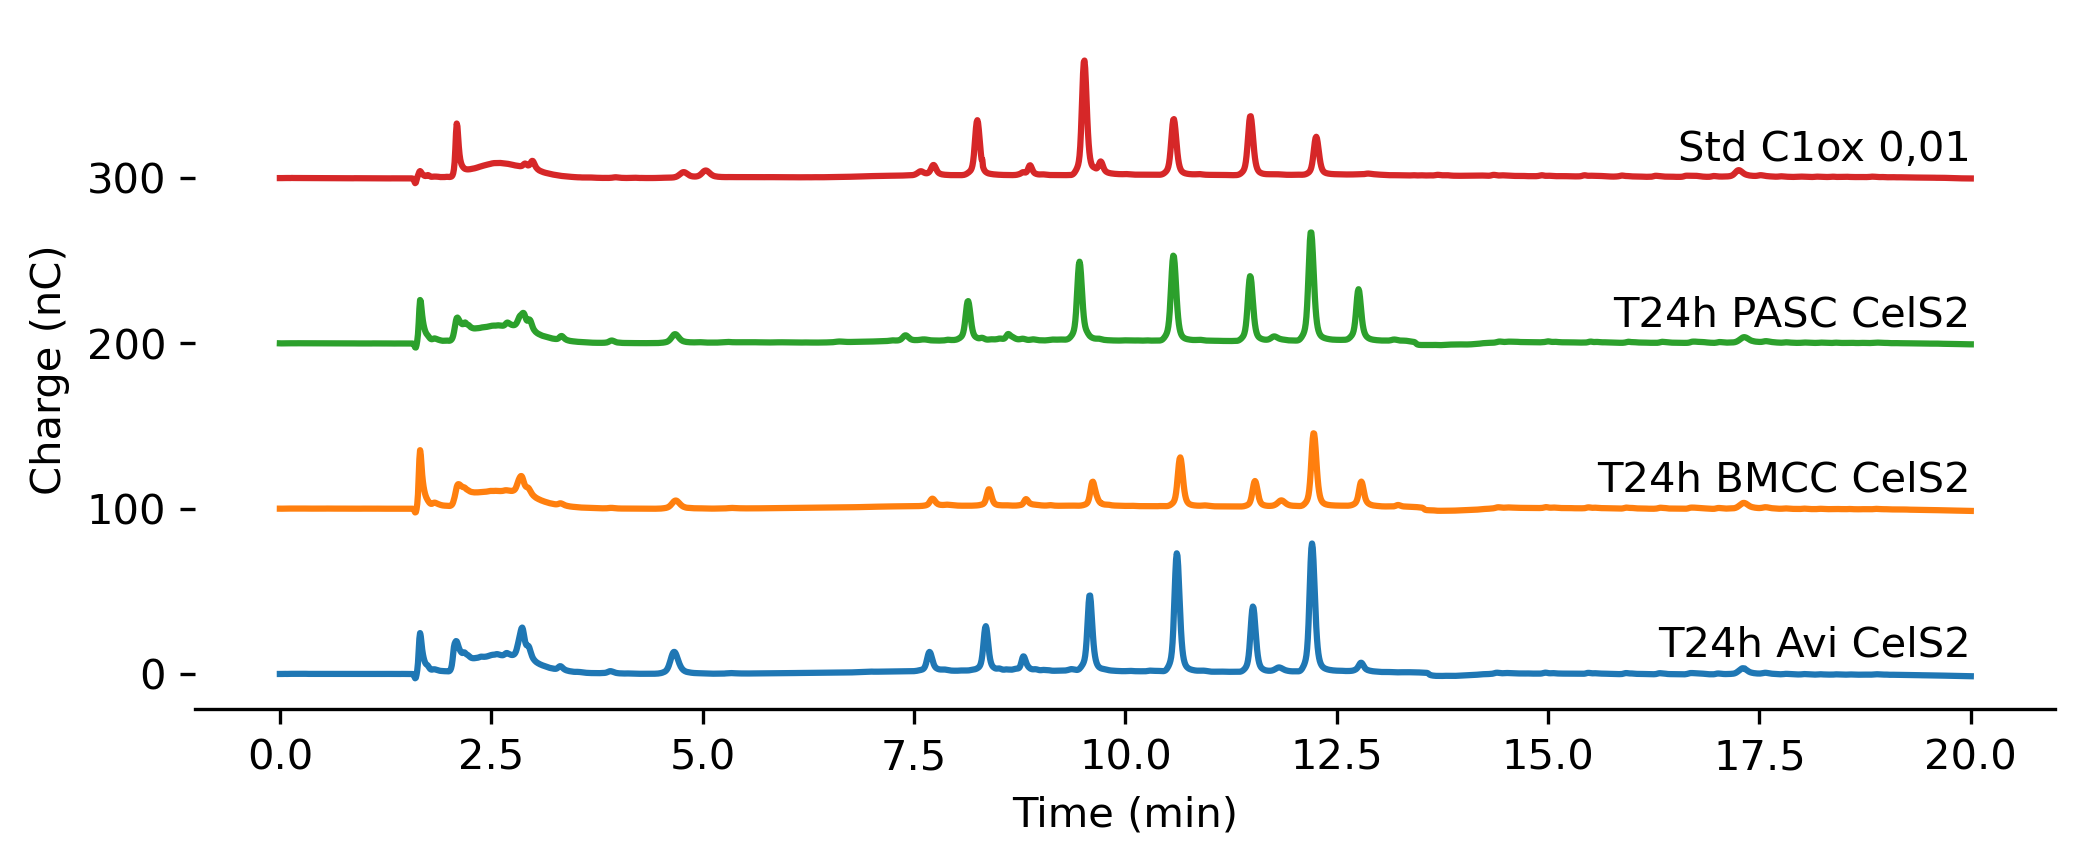

In [5]:
sns.set_palette('tab10')
cols = [c for c in df_1 if '24' in c and 'CelS2' in c] + [ 'Std_C1ox_0,01_x']
colors = dict(zip(cols, sns.color_palette()))
plot_ics_chrom(df_1, cols, name_len=3, shifty=100, x_min=0, x_max=20, color=colors)

## Plots

In [6]:
path = './sample_data/HPAEC-PAD-1/raw/'
df_1 = get_run_df(path, name_len=3).set_index('time')

<AxesSubplot:xlabel='Time (min)', ylabel='Charge (nC)'>

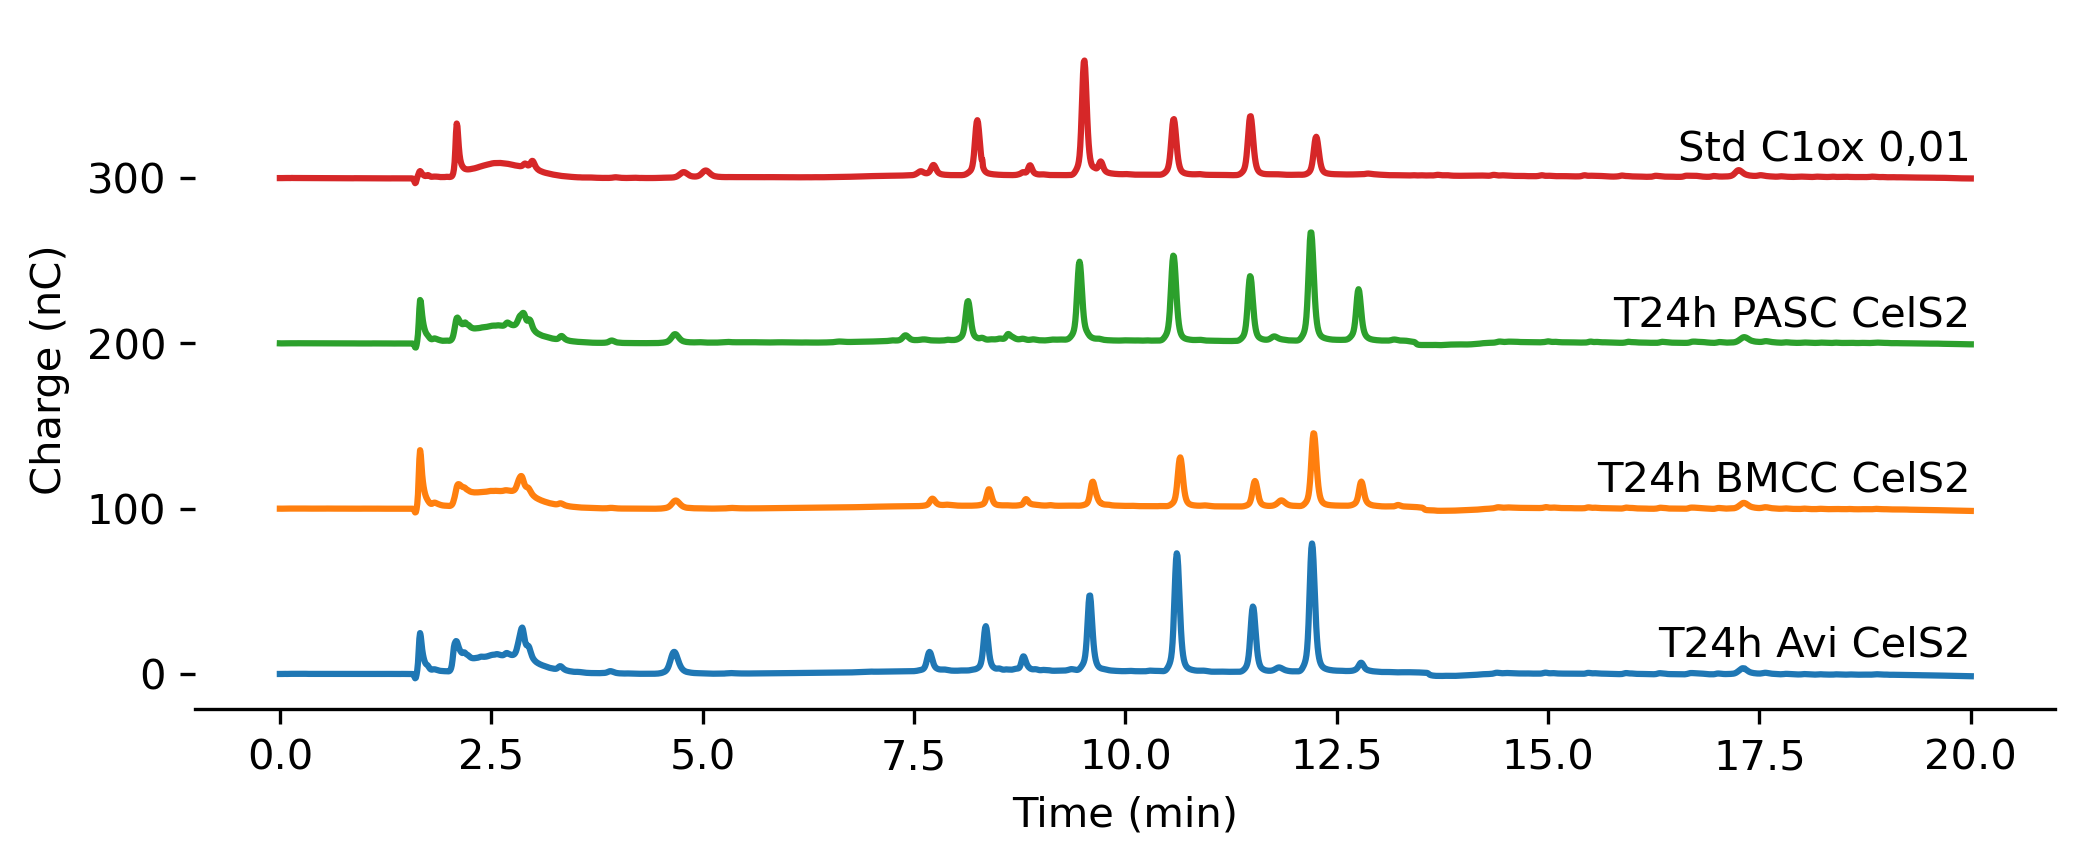

In [7]:
sns.set_palette('tab10')
cols = [c for c in df_1 if '24' in c and 'CelS2' in c] + [ 'Std_C1ox_0,01_x']
colors = dict(zip(cols, sns.color_palette()))
plot_ics_chrom(df_1, cols, name_len=3, shifty=100, x_min=0, x_max=20, color=colors)

<AxesSubplot:xlabel='Time (min)', ylabel='Charge (nC)'>

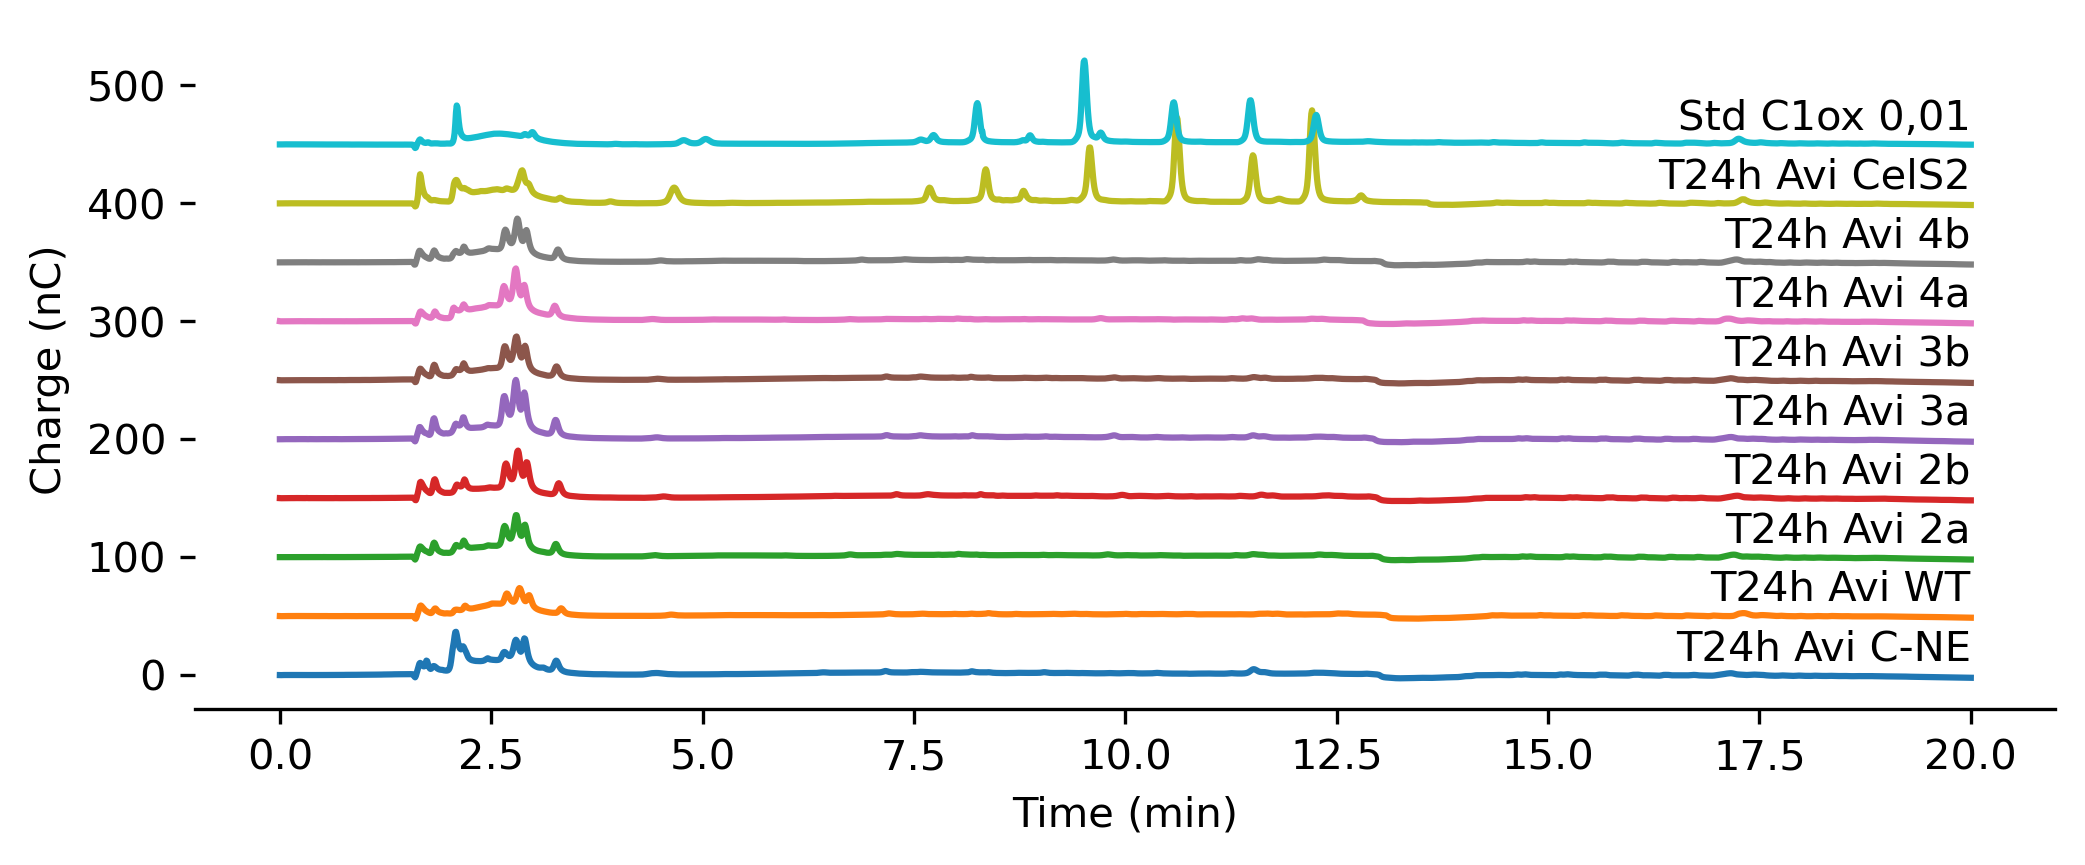

In [8]:

# cols = [c for c in df_1 if '24' in c and 'Avi' in c] + [ 'Std_C1ox_0,01_x']
cols = [
 'T24h_Avi_C-NE',
 'T24h_Avi_WT',
    'T24h_Avi_2a',
 'T24h_Avi_2b',
 'T24h_Avi_3a',
 'T24h_Avi_3b',
 'T24h_Avi_4a',
 'T24h_Avi_4b',
 'T24h_Avi_CelS2',
 'Std_C1ox_0,01_x'
]
colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
plot_ics_chrom(df_1, cols, name_len=3, shifty=50, x_min=0, x_max=20, color=colors)

<AxesSubplot:xlabel='Time (min)', ylabel='Charge (nC)'>

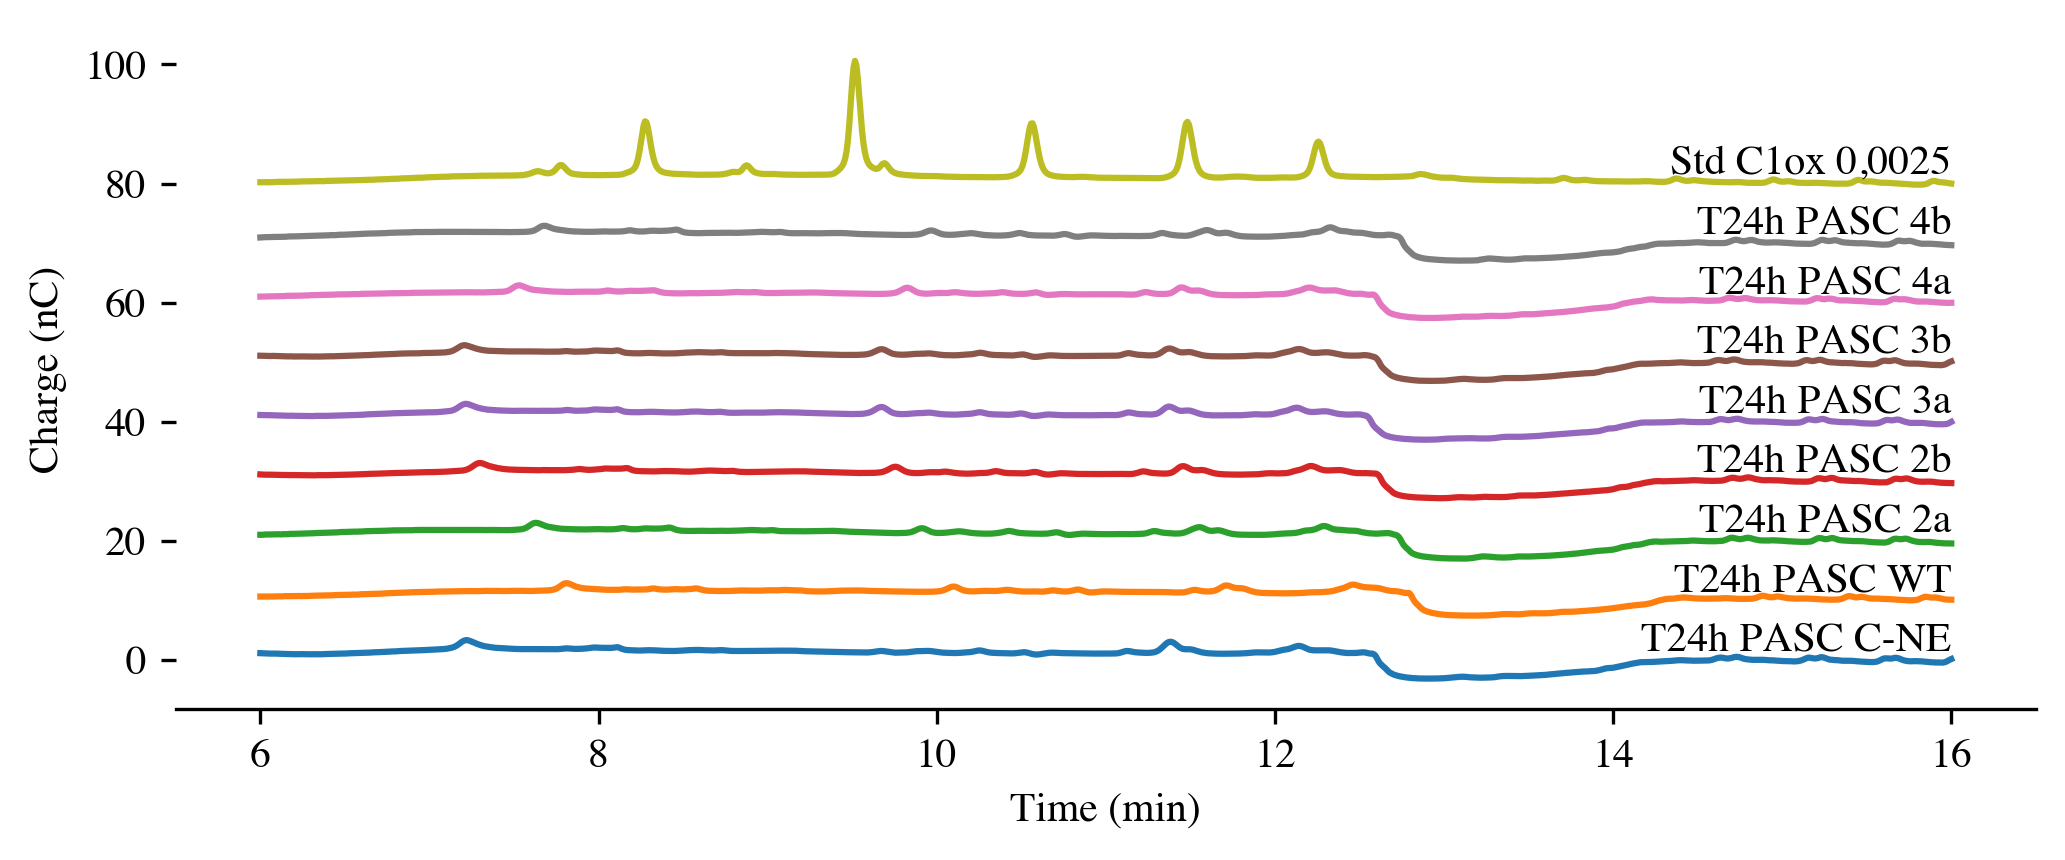

In [ ]:

# cols = [c for c in df_1 if '24' in c and 'Avi' in c] + [ 'Std_C1ox_0,01_x']
cols = [
 'T24h_PASC_C-NE',
 'T24h_PASC_WT',
    'T24h_PASC_2a',
 'T24h_PASC_2b',
 'T24h_PASC_3a',
 'T24h_PASC_3b',
 'T24h_PASC_4a',
 'T24h_PASC_4b',
#  'T24h_Avi_CelS2',
#  'Std_C1ox_0,01_x'
 'Std_C1ox_0,0025_x'
]
colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
plot_ics_chrom(df_1, cols, name_len=3, shifty=10, x_min=6, x_max=16, color=colors, labshift=0.1)

In [ ]:
def align_max_range(col, xmin=5, xmax=7):
    # subset between the desired reference range
    coli = col[col.index.to_series().between(xmin,xmax)]
    tmax = coli.idxmax()
#     time_max = dfi.loc[dfi[col] == maxi, 'time'].iloc[0]

    col.index = col.index - tmax + np.average([xmin, xmax])
    #df = df[df.index >= 0].reset_index(drop=True)
    
    return col

### Plots 4th run

In [12]:
path = './sample_data/HPAEC-PAD-2/raw/'
df_4 = get_run_df(path, skiprows=42, sort_cols=True, rezex=False, idx_inj=99).set_index('time')

In [ ]:
# df_4.columns.to_list()

In [ ]:
# [c for c in df_4 if '7' in c and 'pH6' in c]

In [ ]:
legs = ['No Enz. 0h',
 'No AscA 0h',
 '0h',
 '0.5h',
 '1h',
 '2h',
 '4h',
 '6h',
 '24h',
 'No AscA 24h',
 'No Enz. 24h',
 'Std. C1-ox DP2-3 0.0025 g/L'
]

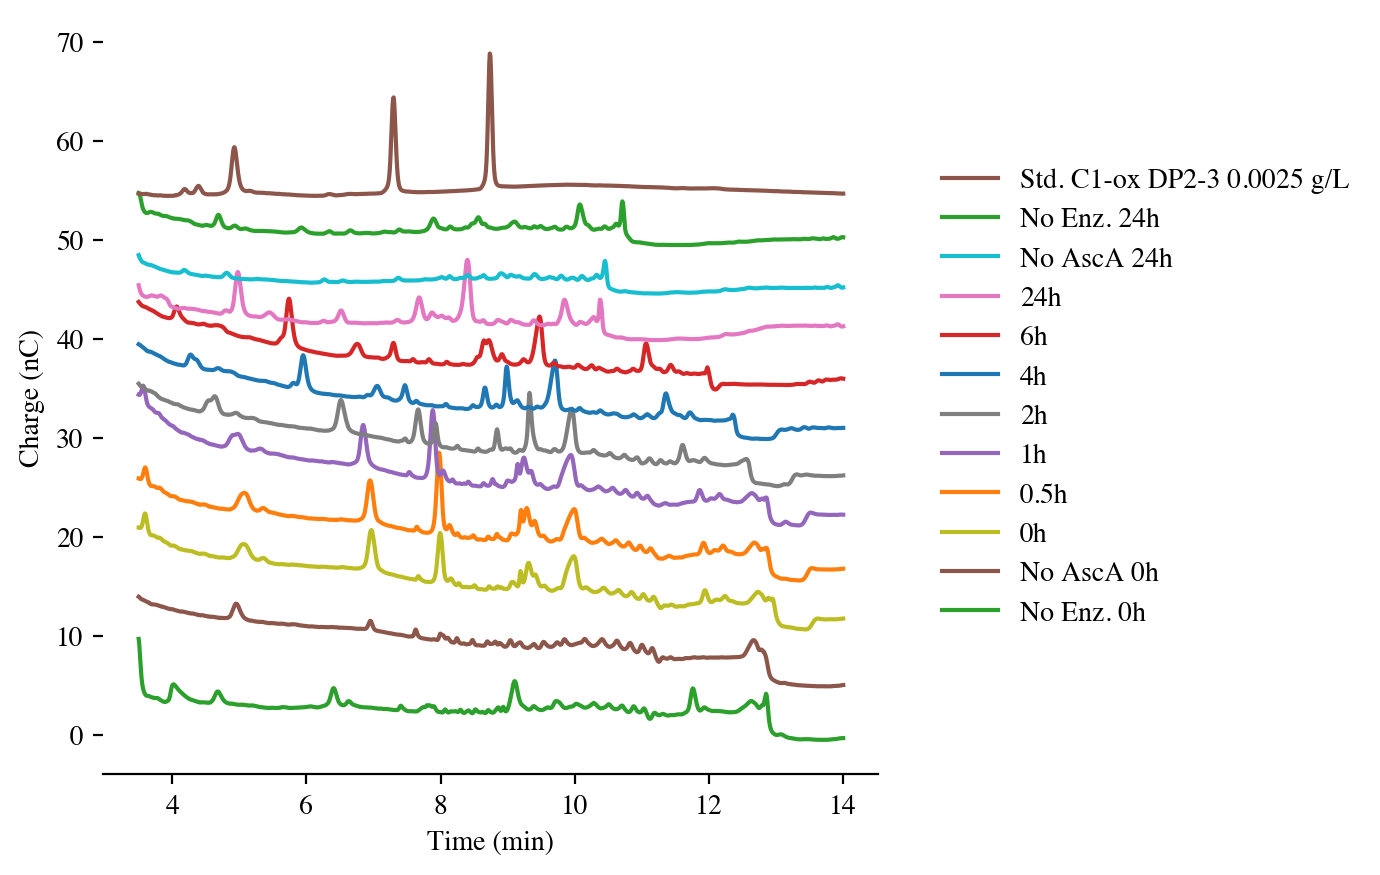

In [ ]:
cols = [ 

    'C-NE_00h-EGS_.txt',
    '7_00h-EGS_NA.txt',
    '7_00h-EGS_1.txt',
'7_00.5h-EGS_1.txt',
 '7_01h-EGS_1.txt',
 '7_02h-EGS_1.txt',
 '7_04h-EGS_1.txt',
 '7_06h-EGS_1.txt',
 '7_24h-EGS_1.txt',
        '7_24h-EGS_NA.txt',
    'C-NE_24h-EGS_.txt',
    'Std_C1ox-0.0025_2.txt',
]
legs = ['No Enz. 0h',
 'No AscA 0h',
 '0h',
 '0.5h',
 '1h',
 '2h',
 '4h',
 '6h',
 '24h',
 'No AscA 24h',
 'No Enz. 24h',
 'Std. C1-ox DP2-3 0.0025 g/L'
]
shifty=5
# colors = dict(zip(cols, sns.color_palette()[:len(cols)]))
# shiftx = dict(zip(cols, [-.06, 0.03, -0.18,0.01, 0.02, 0]))

# Make a plot
ax = plot_ics_chrom(
    df_4, cols, 
    log_y=False, 
    x_min=3.5, x_max=14,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
    figsize=(5, 5), dpi=200,
#     color=colors
)

h, l = ax.get_legend_handles_labels()
legends = dict(zip(l, legs))

l = [legends[i] for i in l]
ax.legend(h[::-1], l[::-1], bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_yticks([])

shftx is dict, lims: 2.86, 13.7
sample: 7_24h-EGS-pH6_NA.txt  shiftx: 0.7
sample: 7_24h-EGS-pH6_1.txt  shiftx: 0.7
shftx is dict, lims: 2.86, 13.7
sample: 7_24h-EGS-pH6-Dil1-5_3.txt  shiftx: -0.14
sample: 7_24h-EGS-pH6-Std0.0025_1.txt  shiftx: -0.14
sample: 7_24h-EGS-pH6-Std0.005_2.txt  shiftx: -0.14
shftx is dict, lims: 2.86, 13.7
sample: Std_C1ox-0.00125_1.txt  shiftx: 0


Text(0.5, 0, 'Time (min)')

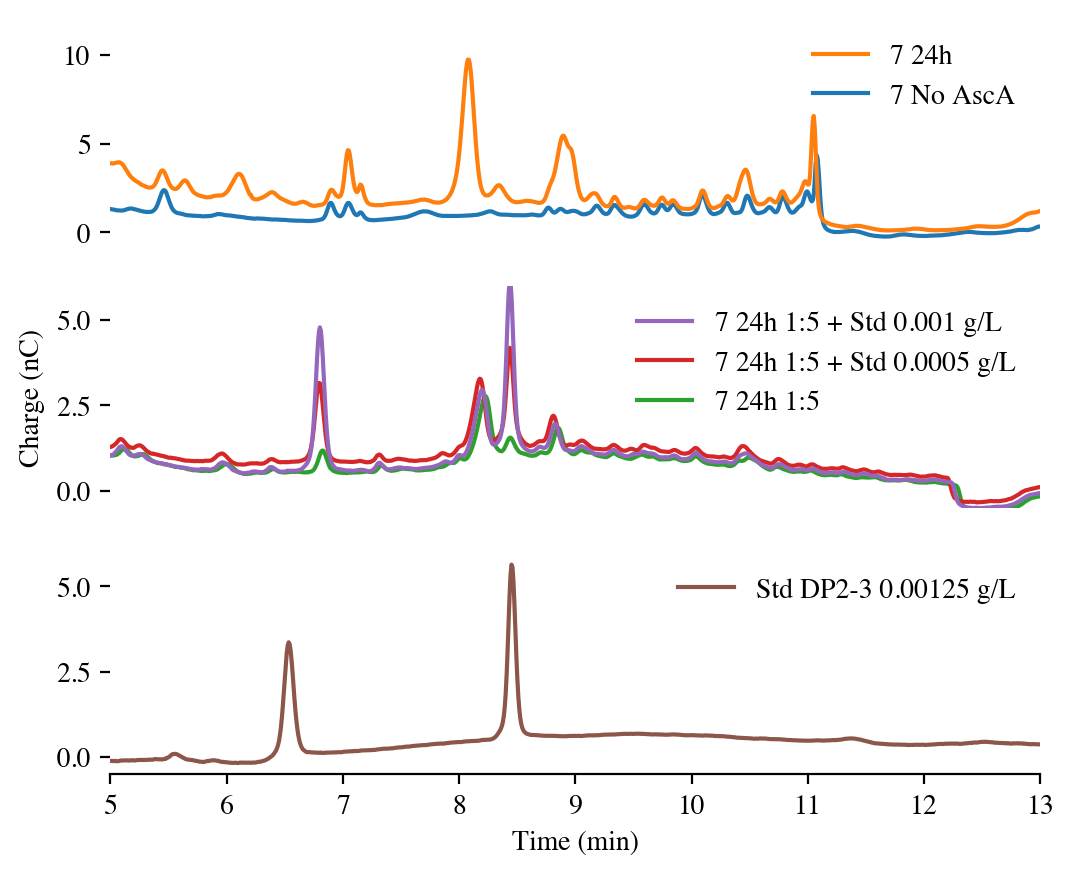

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

<Figure size 2400x900 with 0 Axes>

In [ ]:
legso = ['7 24h-EGS-pH6 NA.txt',
         '7 24h-EGS-pH6 1.txt',
         '7 24h-EGS-pH6-Dil1-5 3.txt',
         '7 24h-EGS-pH6-Std0.0025 1.txt',
         '7 24h-EGS-pH6-Std0.005 2.txt',
         'Std C1ox-0.00125 1.txt'
]
legsf = ['7 No AscA',
         '7 24h',
         '7 24h 1:5',
         '7 24h 1:5 + Std 0.0005 g/L',
         '7 24h 1:5 + Std 0.001 g/L',
         'Std DP2-3 0.00125 g/L'
]
legs = dict(zip(legso, legsf))

x_min=3
x_max=13
cols = [
#     'ne_24h-EGS_', 
    '7_24h-EGS-pH6_NA.txt',
         '7_24h-EGS-pH6_1.txt',
'7_24h-EGS-pH6-Dil1-5_3.txt',
 '7_24h-EGS-pH6-Std0.0025_1.txt',
 '7_24h-EGS-pH6-Std0.005_2.txt',
 'Std_C1ox-0.00125_1.txt',

#         'CelS2_24h-EGS_1.txt',
]

colors = dict(zip(cols, sns.color_palette()[:len(cols)]))

shiftsx = [
    0,
    -0.14,
    -0.14,
    -0.14,
    0.7,
    0.7,
#     0,
]
shiftsy = [
    15,
    9,
    9,
    9,
    0,
    0,
]

shiftsx = shiftsx[::-1]
shiftsy = shiftsy[::-1]

shiftx = dict(zip(cols, shiftsx))
shifty = 0 #dict(zip(cols, shiftsy))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,5), dpi=200, sharex=False)
# Make a plot
plot_ics_chrom(df_4, cols[:2], 
    log_y=False, 
    x_min=x_min, x_max=x_max,
    #y_max=530,
    shifty=shifty,
    shiftx=shiftx,
    name_len=3,
#     figsize=(5, 5), dpi=200,
    color=colors,
ax=ax1)
plot_ics_chrom(df_4, cols[2:5], 
    log_y=False, 
    x_min=x_min, x_max=x_max,
    #y_max=530,
    shifty=shifty,
    shiftx=shiftx,
    name_len=3,
#     figsize=(5, 5), dpi=200,
    color=colors,
ax=ax2)
plot_ics_chrom(df_4, cols[5:], 
    log_y=False, 
    x_min=x_min, x_max=x_max,
    #y_max=530,
    shifty=shifty,
    shiftx=shiftx,
    name_len=3,
#     figsize=(5, 5), dpi=200,
    color=colors,
ax=ax3)

for ax in (ax1, ax2, ax3):
    ax.set_xlim(5, x_max)
    ax.set_ylim(-0.5, 6)
    ax.set_xlabel('')
    h, l = ax.get_legend_handles_labels()
    l = [legs[i] for i in l]
    ax.legend(h[::-1], l[::-1],
#               bbox_to_anchor=[1.05, 0.5], 
              loc='upper right',
              frameon=False)
ax3.set_ylabel('')
ax1.set_ylabel('')
ax1.set_ylim(-0.5, 12)
# ax.set_yticklabels([])
# ax.set_yticks([])
sns.despine(fig=fig, left=True)
sns.despine(ax=ax1, bottom=True, left=True)
sns.despine(ax=ax2, bottom=True, left=True)
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xlabel('Time (min)')

In [ ]:
# [c for c in df_4 if 'td' in c]

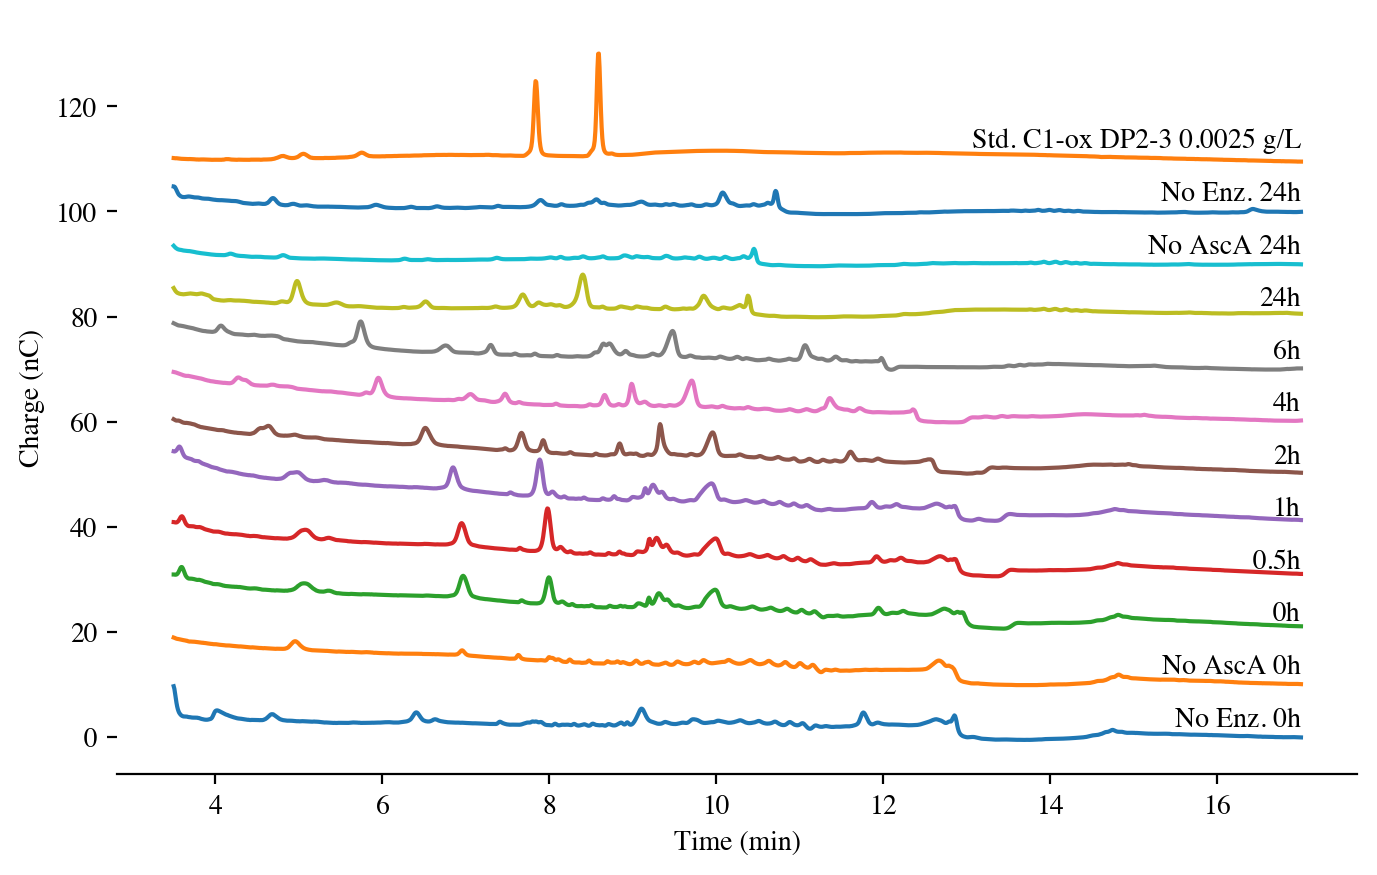

In [ ]:
cols = [ 
    'C-NE_00h-EGS_.txt',
    '7_00h-EGS_NA.txt',
    '7_00h-EGS_1.txt',
    '7_00.5h-EGS_1.txt',
    '7_01h-EGS_1.txt',
    '7_02h-EGS_1.txt',
    '7_04h-EGS_1.txt',
    '7_06h-EGS_1.txt',
    '7_24h-EGS_1.txt',
    '7_24h-EGS_NA.txt',
    'C-NE_24h-EGS_.txt',
    'Std_C1ox-0.0025_3.txt',
]
legs = ['No Enz. 0h',
 'No AscA 0h',
 '0h',
 '0.5h',
 '1h',
 '2h',
 '4h',
 '6h',
 '24h',
 'No AscA 24h',
 'No Enz. 24h',
 'Std. C1-ox DP2-3 0.0025 g/L'
]
shiftsx = [ 
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    0
]
shifty=10
colors = dict(zip(cols, (sns.color_palette('tab10', len(cols)))))
shiftx = dict(zip(cols, shiftsx))
nwlabs=dict(zip(cols, legs))

# Make a plot
ax = plot_ics_chrom(
    df_4, cols, 
    log_y=False, 
    x_min=3.5, x_max=17,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
    figsize=(8, 5), dpi=200,
    color=colors, nwlabs=nwlabs, labshift=1
)

# h, l = ax.get_legend_handles_labels()
# legends = dict(zip(l, legs))

# l = [legends[i] for i in l]
# ax.legend(h[::-1], l[::-1], bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_yticks([])

#### Protein 4 vs CelS2

In [ ]:
# [c for c in df_4 if 'ox' in c]

Text(0.5, 0, '')

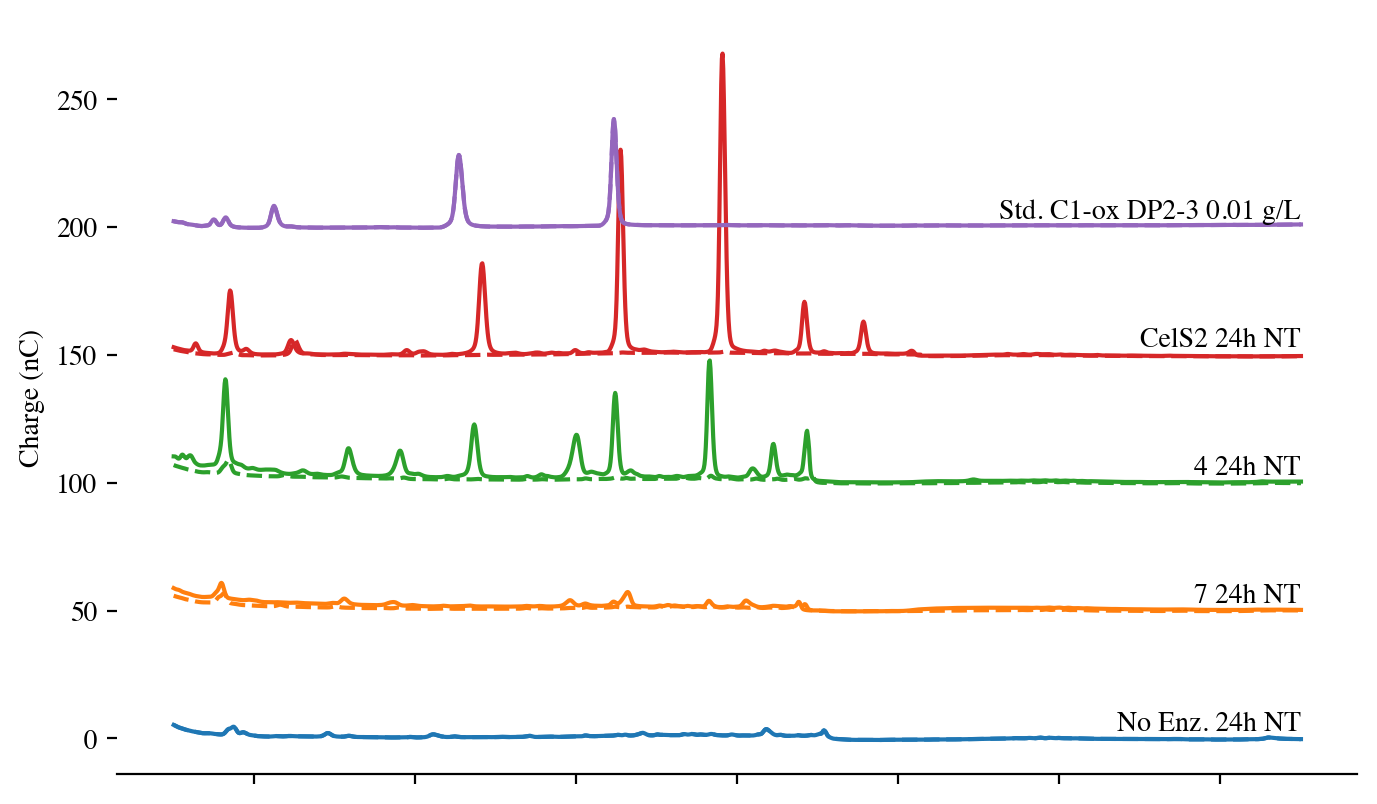

In [14]:
cols_2 = [ 
    'C-NE_24h-NT_.txt',
#     '7_24h-NT_1.txt',
#     '7_24h-NT_2.txt',
#     '7_24h-NT_3.txt',
    '7_24h-NT_NA.txt',
#     '4_24h-NT_1.txt',
#     '4_24h-NT_2.txt',
#     '4_24h-NT_3.txt',
    '4_24h-NT_NA.txt',
#     'CelS2_24h-NT_1.txt',
#     'CelS2_24h-NT_2.txt',
#     'CelS2_24h-NT_3.txt',
    'CelS2_24h-NT_NA.txt',
     'Std_C1ox-0.01_1.txt',

]
cols = [ 
    'C-NE_24h-NT_.txt',
    '7_24h-NT_1.txt',
#     '7_24h-NT_2.txt',
#     '7_24h-NT_3.txt',
#     '7_24h-NT_NA.txt',
    '4_24h-NT_1.txt',
#     '4_24h-NT_2.txt',
#     '4_24h-NT_3.txt',
#     '4_24h-NT_NA.txt',
    'CelS2_24h-NT_1.txt',
#     'CelS2_24h-NT_2.txt',
#     'CelS2_24h-NT_3.txt',
#     'CelS2_24h-NT_NA.txt',
     'Std_C1ox-0.01_1.txt',

]
legs = ['No Enz. 24h NT',
 '7 24h NT',
 '4 24h NT',
 'CelS2 24h NT',
 'Std. C1-ox DP2-3 0.01 g/L',
]
shiftsx = [ 
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    0
]
shifty=50
colors = dict(zip(cols, (sns.color_palette()+sns.color_palette('tab10', 15))[:len(cols)]))
colors_2 = dict(zip(cols_2, (sns.color_palette()+sns.color_palette('tab10', 15))[:len(cols_2)]))
shiftx = dict(zip(cols, shiftsx))
nwlabs=dict(zip(cols, legs))

# Make a plot
ax = plot_ics_chrom(
    df_4, cols, 
    log_y=False, 
    x_min=3, x_max=17,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
    figsize=(8, 5), dpi=200,
    color=colors,
    nwlabs=nwlabs,
    labshift=1
)

ax = plot_ics_chrom(
    df_4, cols_2, 
    log_y=False, 
    x_min=3, x_max=17,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
#     figsize=(6, 3), dpi=200,
    color=colors_2, style='--',
#     nwlabs=nwlabs,
    labshift=1, ax=ax, unlabel=True
)
# h, l = ax.get_legend_handles_labels()
# legends = dict(zip(l, legs))

# l = [legends[i] for i in l]
# ax.legend(h[::-1], l[::-1], bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xlabel('')

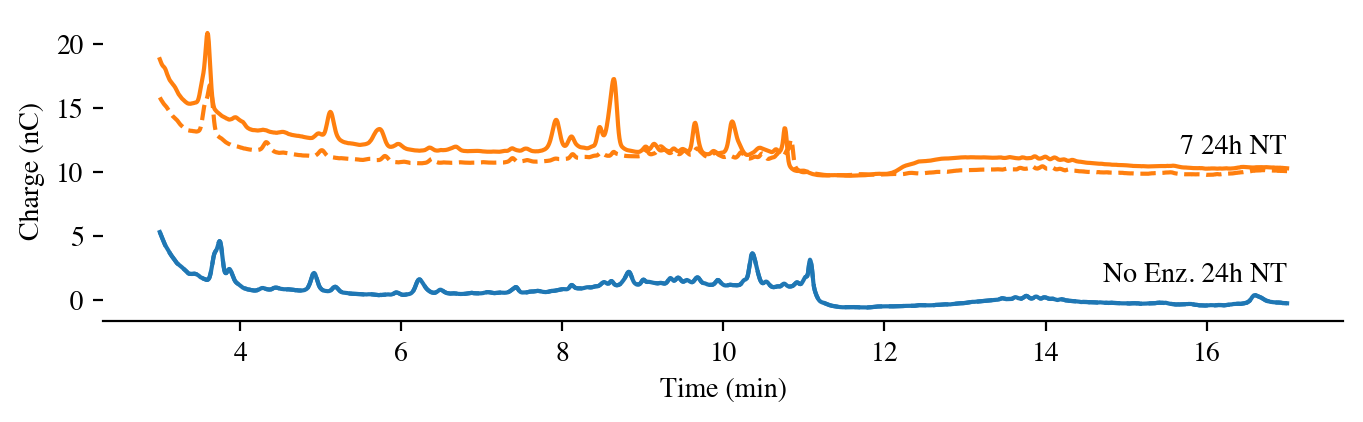

In [15]:
cols_2 = [ 
    'C-NE_24h-NT_.txt',
#     '7_24h-NT_1.txt',
#     '7_24h-NT_2.txt',
#     '7_24h-NT_3.txt',
    '7_24h-NT_NA.txt',
#     '4_24h-NT_1.txt',
#     '4_24h-NT_2.txt',
#     '4_24h-NT_3.txt',
#     '4_24h-NT_NA.txt',
#     'CelS2_24h-NT_1.txt',
#     'CelS2_24h-NT_2.txt',
#     'CelS2_24h-NT_3.txt',
#     'CelS2_24h-NT_NA.txt',
#      'Std_C1ox-0.00125_1.txt',

]
cols = [ 
    'C-NE_24h-NT_.txt',
    '7_24h-NT_1.txt',
#     '7_24h-NT_2.txt',
#     '7_24h-NT_3.txt',
#     '7_24h-NT_NA.txt',
#     '4_24h-NT_1.txt',
#     '4_24h-NT_2.txt',
#     '4_24h-NT_3.txt',
#     '4_24h-NT_NA.txt',
#     'CelS2_24h-NT_1.txt',
#     'CelS2_24h-NT_2.txt',
#     'CelS2_24h-NT_3.txt',
#     'CelS2_24h-NT_NA.txt',
#      'Std_C1ox-0.00125_1.txt',

]
legs = [
    'No Enz. 24h NT',
 '7 24h NT',
#  '4 24h NT',
#  'CelS2 24h NT',
#  'Std. C1-ox DP2-3 0.00125 g/L',
]
shiftsx = [ 
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    0
]
shifty=10
colors = dict(zip(cols, (sns.color_palette()+sns.color_palette('tab10', 15))[:len(cols)]))
colors_2 = dict(zip(cols_2, sns.color_palette()[:len(cols_2)]))
shiftx = dict(zip(cols, shiftsx))
nwlabs=dict(zip(cols, legs))

# Make a plot
ax = plot_ics_chrom(
    df_4, cols, 
    log_y=False, 
    x_min=3, x_max=17,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
    figsize=(8, 2), dpi=200,
    color=colors,
    nwlabs=nwlabs,
    labshift=1
)

ax = plot_ics_chrom(
    df_4, cols_2, 
    log_y=False, 
    x_min=3, x_max=17,
    #y_max=530,
    shifty=shifty,
#     shiftx=shiftx,
    name_len=3,
#     figsize=(6, 3), dpi=200,
    color=colors_2, style='--',
#     nwlabs=nwlabs,
    labshift=1, ax=ax, unlabel=True
)
# h, l = ax.get_legend_handles_labels()
# legends = dict(zip(l, legs))

# l = [legends[i] for i in l]
# ax.legend(h[::-1], l[::-1], bbox_to_anchor=[1.05, 0.5], loc='center left', frameon=False)

# ax.set_ylabel('')
# ax.set_yticklabels([])
# ax.set_yticks([])

## Rezex

In [17]:
path_rz = './sample_data/UHPLC/raw/'

In [18]:
df_rz = get_run_df(path_rz, skiprows=42, sort_cols=True, rezex=True)

In [19]:
df_rz = df_rz.set_index('time')

In [20]:
df_rz

,4_00.5h-ChiBS_1,4_00.5h-ChiBS_2,4_00.5h-ChiBS_3,4_00h-ChiBS_1,4_00h-ChiBS_2,4_00h-ChiBS_3,4_00h-ChiBS_NA,4_01h-ChiBS_1,4_01h-ChiBS_2,4_01h-ChiBS_3,...,Sc10D_24h-ChiBI_3,Sc10D_24h-ChiBI_NA,Sc10D_24h-ChiBS_1,Sc10D_24h-ChiBS_2,Sc10D_24h-ChiBS_3,Sc10D_24h-ChiBS_NA,Sc10D_24h-NT_1,Sc10D_24h-NT_2,Sc10D_24h-NT_3,Sc10D_24h-NT_NA
time,,,,,,,,,,,,,,,,,,,,,
0.0000,-0.053158,-0.013200,-0.020542,-0.051451,-0.048819,-0.042612,-0.029342,0.004005,-0.065564,-0.045387,...,-0.082952,0.003051,-0.002414,-0.039444,-0.112916,-0.115470,0.035134,-0.150372,-0.077115,-0.136170
0.0017,-0.095302,-0.047054,-0.053504,-0.070525,-0.074292,-0.079619,-0.065539,-0.039420,-0.041741,-0.022089,...,-0.061136,-0.039312,-0.004287,-0.083989,-0.098561,-0.107046,0.036839,-0.193876,-0.073503,-0.150218
0.0033,-0.034402,-0.036423,-0.020797,-0.062849,-0.064553,-0.064705,-0.048639,-0.022337,-0.103244,0.006707,...,-0.052966,-0.025516,-0.027590,-0.070500,-0.089592,-0.157580,0.002028,-0.142315,-0.107346,-0.152929
0.0050,-0.047055,-0.034664,-0.002124,-0.055716,-0.056458,-0.045993,-0.081228,-0.035164,-0.098460,-0.015680,...,-0.073187,-0.008335,-0.011435,-0.073952,-0.109291,-0.084582,0.040299,-0.140218,-0.097844,-0.141137
0.0067,-0.044345,-0.016598,-0.033700,-0.046779,-0.071770,-0.075393,-0.029731,-0.040836,-0.056026,-0.102746,...,-0.056612,-0.020533,0.002968,-0.120805,-0.061864,-0.120812,-0.000254,-0.159188,-0.103452,-0.123214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.9933,0.043151,0.052005,0.003935,0.058884,0.017441,-0.042687,-0.038897,0.115375,-0.075056,0.074991,...,0.130731,-0.055306,0.561160,0.432192,0.314238,-0.150991,0.426332,0.353630,0.174419,-0.323913
5.9950,0.016822,0.061936,0.050385,0.045013,-0.029569,-0.072773,-0.041119,0.139155,-0.013278,0.061540,...,0.115391,-0.080874,0.598051,0.452722,0.324928,-0.159191,0.438445,0.366076,0.184701,-0.272567
5.9967,0.078526,0.066574,0.005963,0.095110,0.017756,-0.094178,-0.007866,0.093682,-0.018169,0.077888,...,0.110408,-0.142318,0.539157,0.498514,0.276019,-0.180925,0.416601,0.363659,0.138016,-0.292174


In [21]:
# [c for c in df_rz if 'ox' in c and '' in c]

In [22]:
cols = [c for c in df_rz if 'Sc10D_24h' in c and 'ChiB' in c]
cols += ['A2ox_100µM_1']

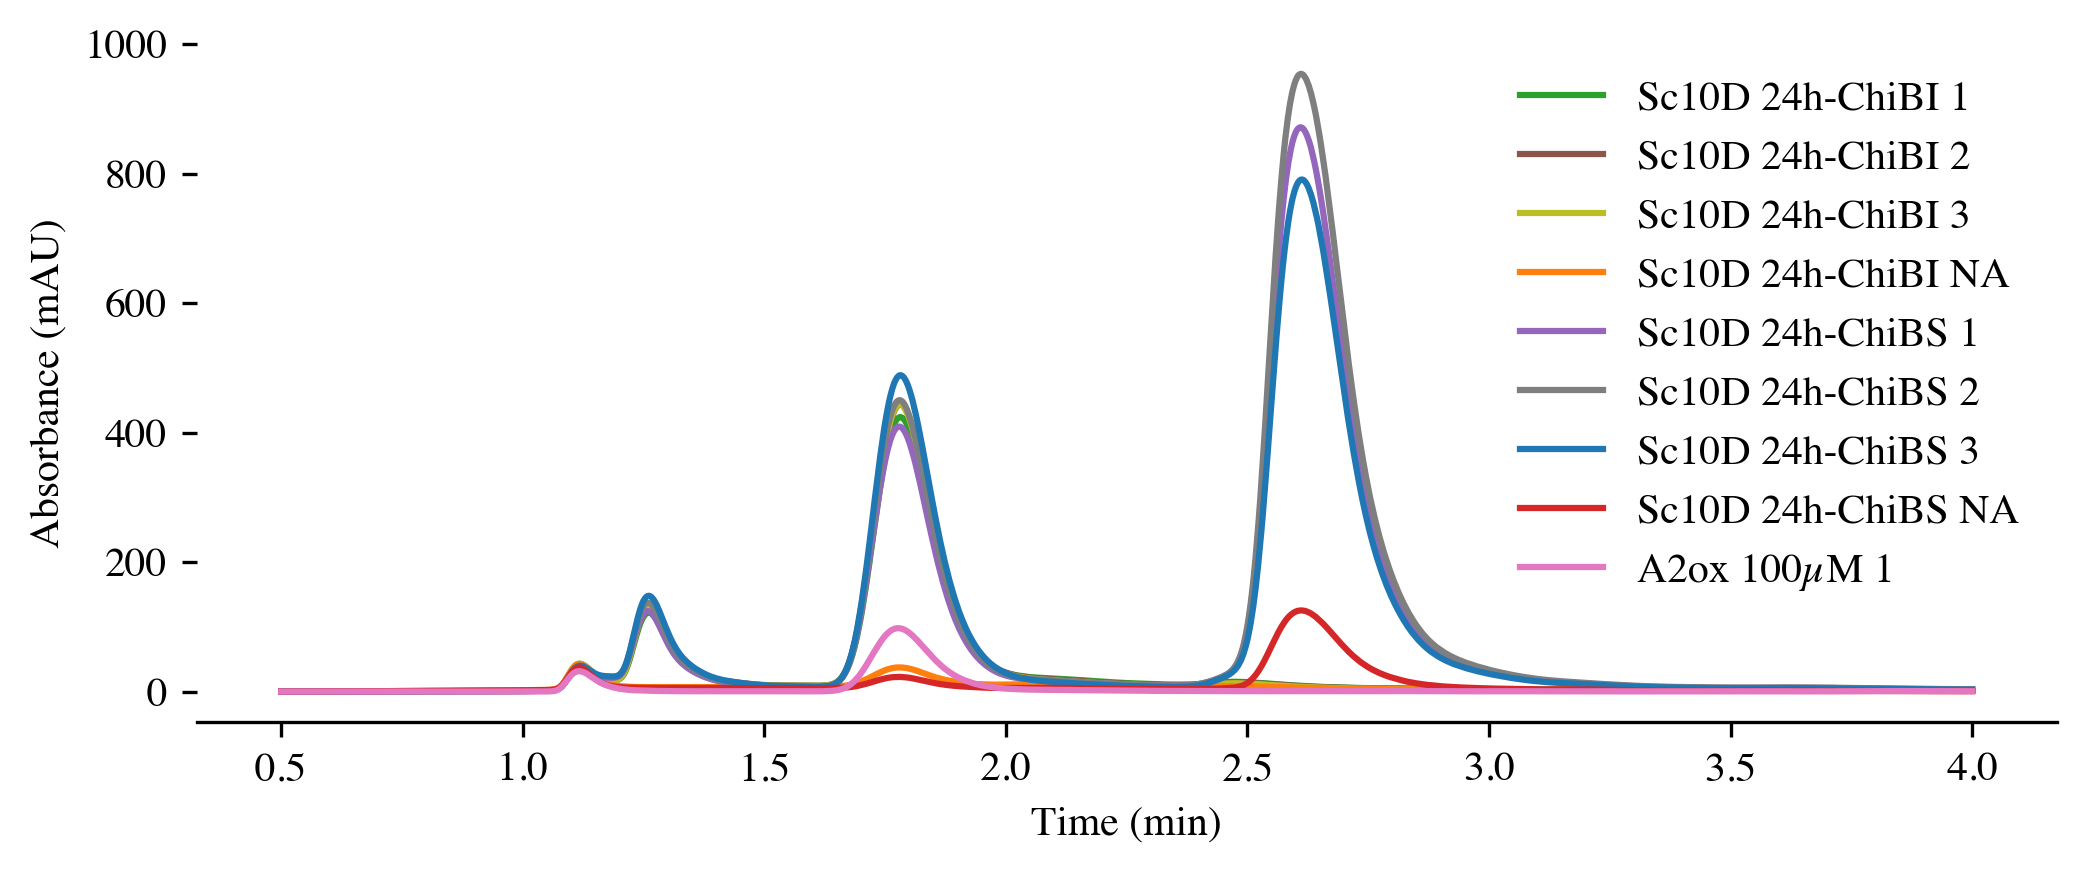

In [23]:
ax = plot_ics_chrom(df_rz, cols, x_min=0.5, x_max=4, y_min=None, y_max=None, ax=None, 
                    log_y=False,
#                     shifty=150, shiftx=0,
                    name_len=3,
                    figsize=(8,3), dpi=300,
                    ylabel='Absorbance (mAU)',
                    no_negatives=False)

In [ ]:
[c for c in df_rz if '24h-ChiBS_1' in c] + ['A2ox_100µM_1']

['4_24h-ChiBS_1', '7_24h-ChiBS_1', 'Sc10D_24h-ChiBS_1', 'A2ox_100µM_1']

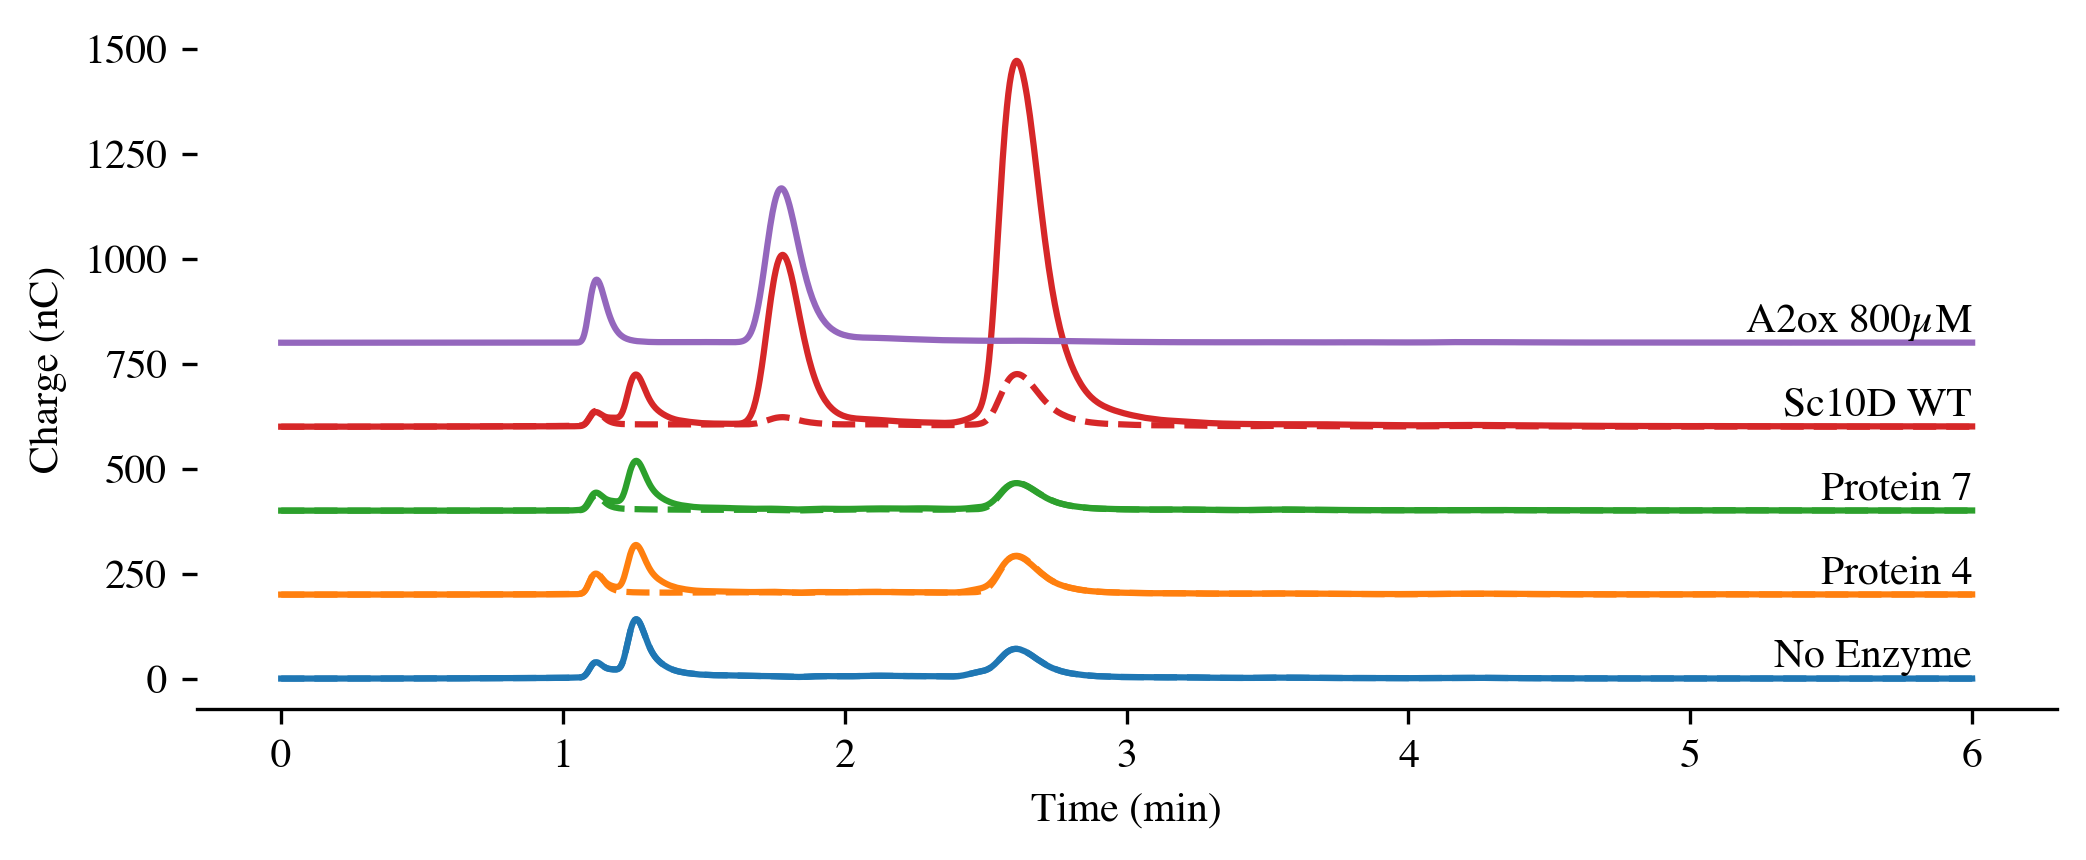

In [24]:
cols = ['C-NE_24h-ChiBS_']+[c for c in df_rz if '24h-ChiBS_1' in c] + [ 'A2ox_800µM_1']
nwlabs = ['No Enzyme', 'Protein 4', 'Protein 7', 'Sc10D WT', 'A2ox 800µM']
colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
ax = plot_ics_chrom(df_rz, cols,
#                     x_min=0, x_max=6,
#                     y_min=None, y_max=None, ax=None, 
                    log_y=False, shifty=200, shiftx=0, name_len=2,
                    figsize=(8,3), dpi=300, nwlabs=dict(zip(cols,nwlabs)),
                    ylabel='Absorbance (mAU)',color = colors,
                    no_negatives=False)

cols = ['C-NE_24h-ChiBS_']+[c for c in df_rz if '24h-ChiBS_NA' in c] #+ [ 'A2ox_100µM_1']

colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
ax = plot_ics_chrom(df_rz, cols,
#                     x_min=0, x_max=6,
#                     y_min=None, y_max=None, 
                    ax=ax, style='--',
                    log_y=False, shifty=200, shiftx=0, name_len=2,
#                     figsize=(8,3), dpi=300,
                    unlabel=True,
#                     ylabel='Absorbance (mAU)',
                    color = colors,
                    no_negatives=False)

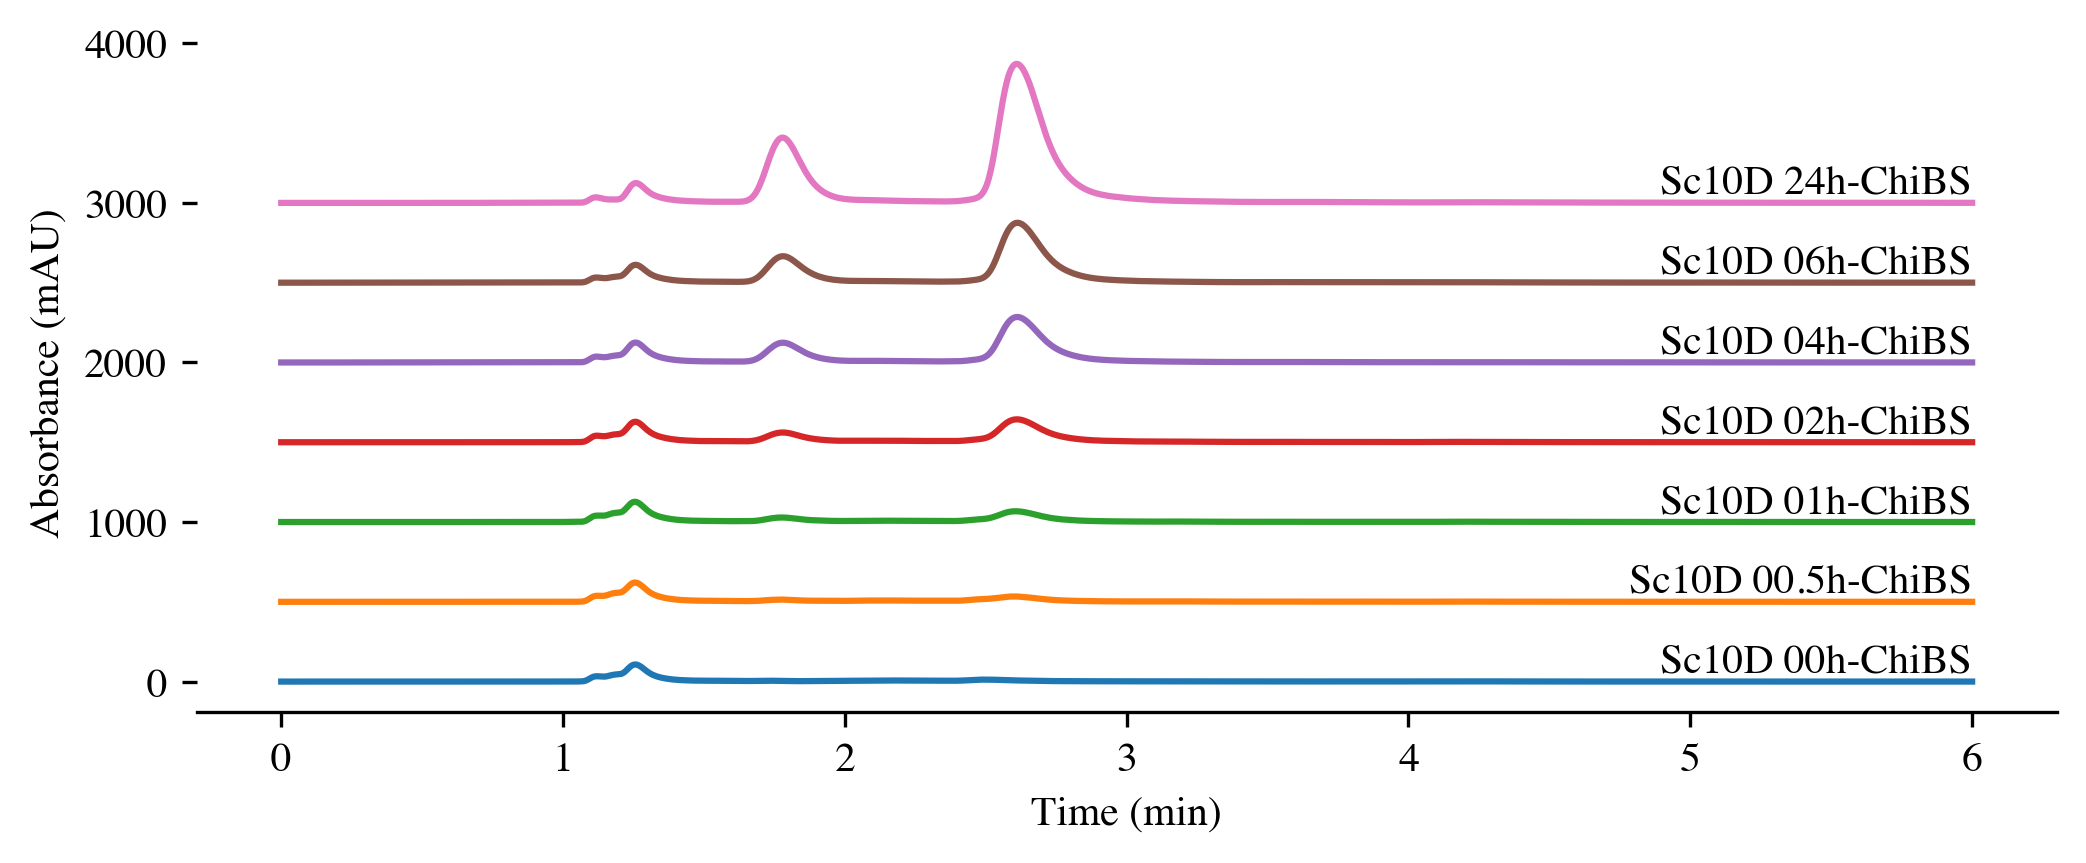

In [ ]:
cols = [c for c in df_rz if 'ChiBS_1' in c and 'Sc10' in c]
cols = [
    'Sc10D_00h-ChiBS_1',
    'Sc10D_00.5h-ChiBS_1',
    'Sc10D_01h-ChiBS_1',
    'Sc10D_02h-ChiBS_1',
    'Sc10D_04h-ChiBS_1',
    'Sc10D_06h-ChiBS_1',
    'Sc10D_24h-ChiBS_1']
colors = dict(zip(cols, sns.color_palette('tab10', len(cols))))
ax = plot_ics_chrom(df_rz, cols,
#                     x_min=0, x_max=6,
#                     y_min=None, y_max=None, ax=None, 
                    log_y=False, shifty=500, shiftx=0, name_len=2,
                    figsize=(8,3), dpi=300,
                    ylabel='Absorbance (mAU)',color = colors,
                    no_negatives=False)

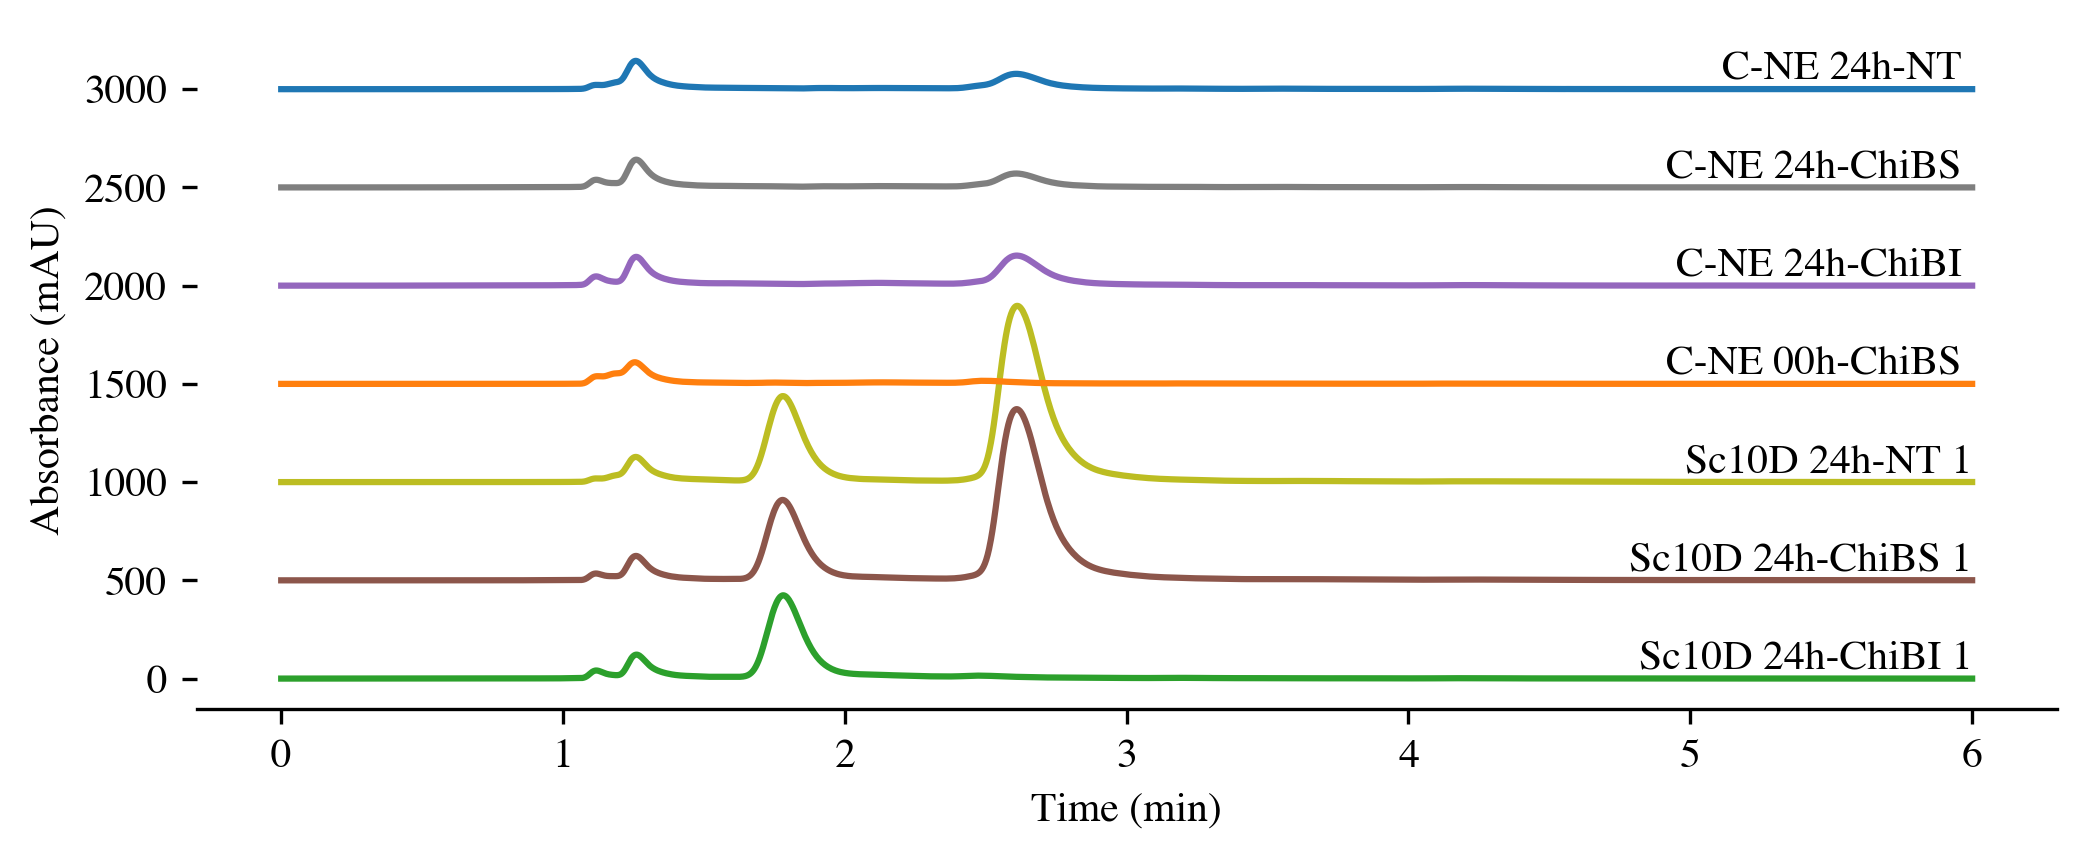

In [25]:
cols = [c for c in df_rz if 'Sc10D' in c and '24' in c and '_1' in c] + [c for c in df_rz if 'NE' in c]

ax = plot_ics_chrom(df_rz, cols,
#                     x_min=0, x_max=6,
#                     y_min=None, y_max=None, ax=None, 
                    log_y=False, shifty=500, shiftx=0, name_len=3,
                    figsize=(8,3), dpi=300,
                    ylabel='Absorbance (mAU)',
                    no_negatives=False, )

In [ ]:
cols = [c for c in df_rz if 'Sc10D' in c]

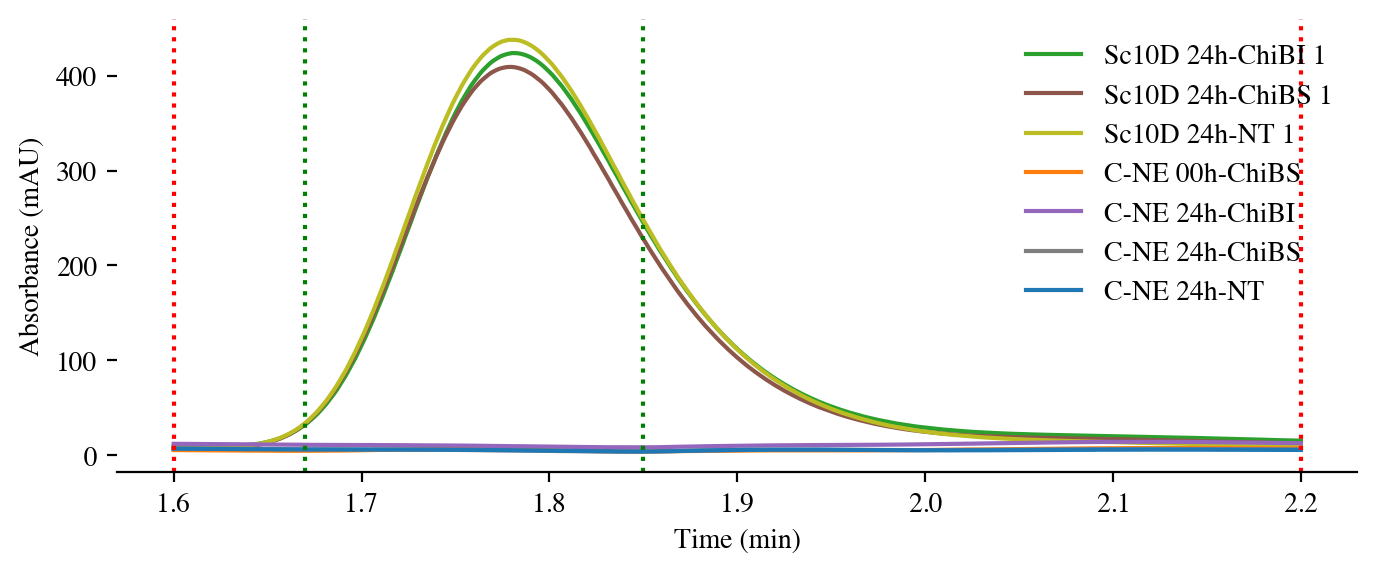

In [27]:

ax = plot_ics_chrom(df_rz, cols, x_min=1.6, x_max=2.2, y_min=None, y_max=None, ax=None, 
                    log_y=False, shifty=0, shiftx=0, name_len=3,
                    figsize=(8,3), dpi=200,
                    ylabel='Absorbance (mAU)',
                    no_negatives=False)
for x in [1.6, 2.2]:
    ax.axvline(x, linestyle=':', color='r')
for x in [1.67, 1.85]:
    ax.axvline(x, linestyle=':', color='g')

## AEC chromatograms

### AEC protein 4

In [ ]:
df_aec_4 = pd.read_csv('../03-Lab_work/2206-Purification/Purification/220607_4C1.csv')

In [ ]:
df_fracs_aec_4 = pd.read_csv(
    '../03-Lab_work/2206-Purification/Purification/fractions_4_AEC.txt',
    sep='\t', skiprows=2,
    names=['no', 'rackloc', 'tubeloc','start','end', 'vol'],
    usecols=['no', 'start', 'end']
)

In [ ]:
# df_aec_4.describe()

In [ ]:
df_fracs_aec_4.head()

,no,start,end
0,1,223.64,225.63
1,2,225.63,227.62
2,3,227.62,229.62
3,4,229.62,231.62
4,5,231.62,233.62


Text(0.5, 0.01, 'Volume (mL)')

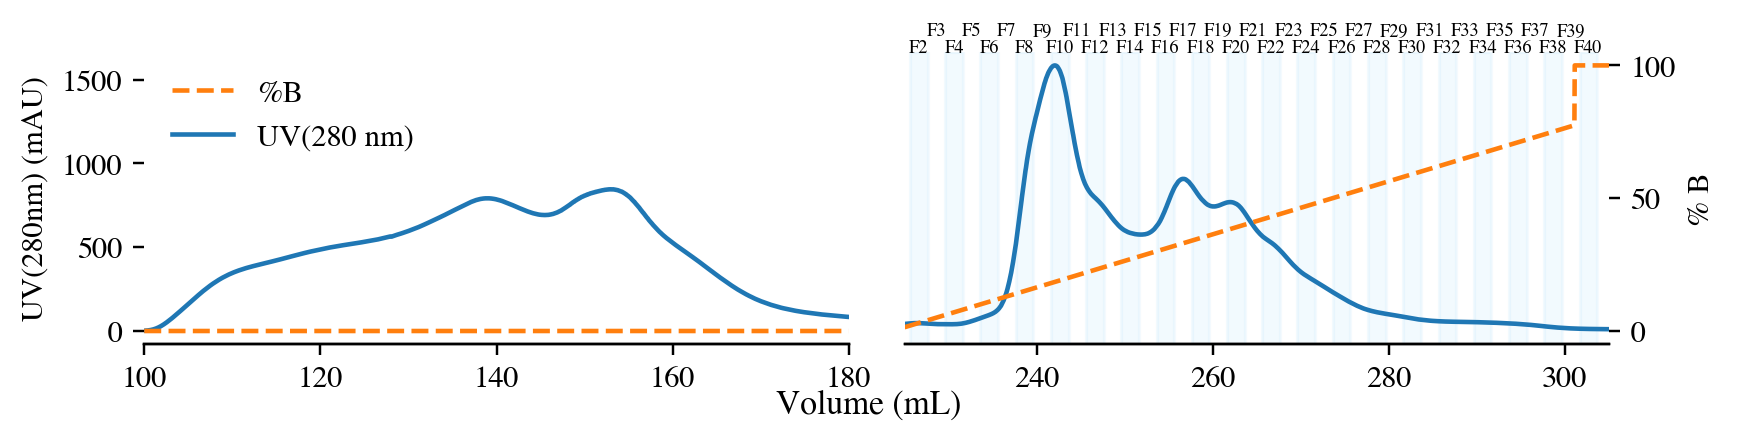

In [ ]:
vrs = [
    'UV(280 nm)',
    '%B',
#     'Flow Rate',
#    'System Pressure',
#    'Conductivity'
]

band_colors = ['lightskyblue', (1,1,1)]

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8,2), dpi=220)
n = 0
for ax in axs:
    h, l = [], []
    
    # Plot fraction bands
    df_fracs_aec_4.apply(lambda x: ax.axvspan(x.start, x.end, color=band_colors[int(x.no%2)], alpha=0.1), axis=1)
    
    # Plot flow
    v = '%B'
    x, y = [c for c in df_aec_4 if v in c]
    color = sns.color_palette('tab10')[1]
    nax = sns.lineplot(x=df_aec_4.loc[df_aec_4[x]>90, x], y=df_aec_4.loc[df_aec_4[x]>90, y], label=v, color=color, ax=ax.twinx(), linestyle='--')
    hi, li = nax.get_legend_handles_labels()
    nax.legend().remove()
    h += hi
    l += li


    # Plot UV
    v = 'UV(280 nm)'
    x, y = [c for c in df_aec_4 if v in c]
    color = sns.color_palette('tab10')[0]
    sns.lineplot(x=df_aec_4.loc[df_aec_4[x]>90, x], y=df_aec_4.loc[df_aec_4[x]>90, y], label=v, color=color, ax=ax)
    hi, li = ax.get_legend_handles_labels()
    h += hi
    l += li
    ax.legend().remove()
    ax.set_xlabel('')

    
    sns.despine(left=True)
    if n == 0:
        ax.set_xlim(100, 180)
        ax.set_ylabel('UV(280nm) (mAU)')
        nax.set_ylabel('')
        nax.set_yticks([])
    else:
        ax.set_xlim(225, 305)
        ax.tick_params(axis='y', length=0)
        df_fracs_aec_4[(df_fracs_aec_4.end < 305) & (df_fracs_aec_4.start > 225)].apply(
            lambda x: nax.text(np.average((x.start, x.end)), 110,
                              'F{}'.format(int(x.no)), fontsize=6,
                              ha='center', va=['top','bottom'][int(x.no%2)]
                             ), axis=1)
        nax.set_ylabel('% B')
#         nax.set_ylim(-10,120)
#         ax.set_ylim(-1600,1900)
    n +=1

# ytx = ax.get_yticks()
# ax.set_yticklabels([])
# axs[0].set_yticks(ytx)

plt.tight_layout()  
axs[0].legend(h, l, frameon=False, loc='upper left')
fig.supxlabel('Volume (mL)', fontsize=11)

### AEC protein 7

In [ ]:
df_aec_7 = pd.read_csv('../03-Lab_work/2206-Purification/Purification/220607_7C3.csv')

In [ ]:
df_fracs_aec_7 = pd.read_csv(
    '../03-Lab_work/2206-Purification/Purification/fractions_7_AEC.txt',
    sep='\t', skiprows=2,
    names=['no', 'rackloc', 'tubeloc','start','end', 'vol'],
    usecols=['no', 'start', 'end']
)

In [ ]:
plt.subplots?

In [ ]:
gridspec.GridSpec?

Text(0.5, 0.01, 'Volume (mL)')

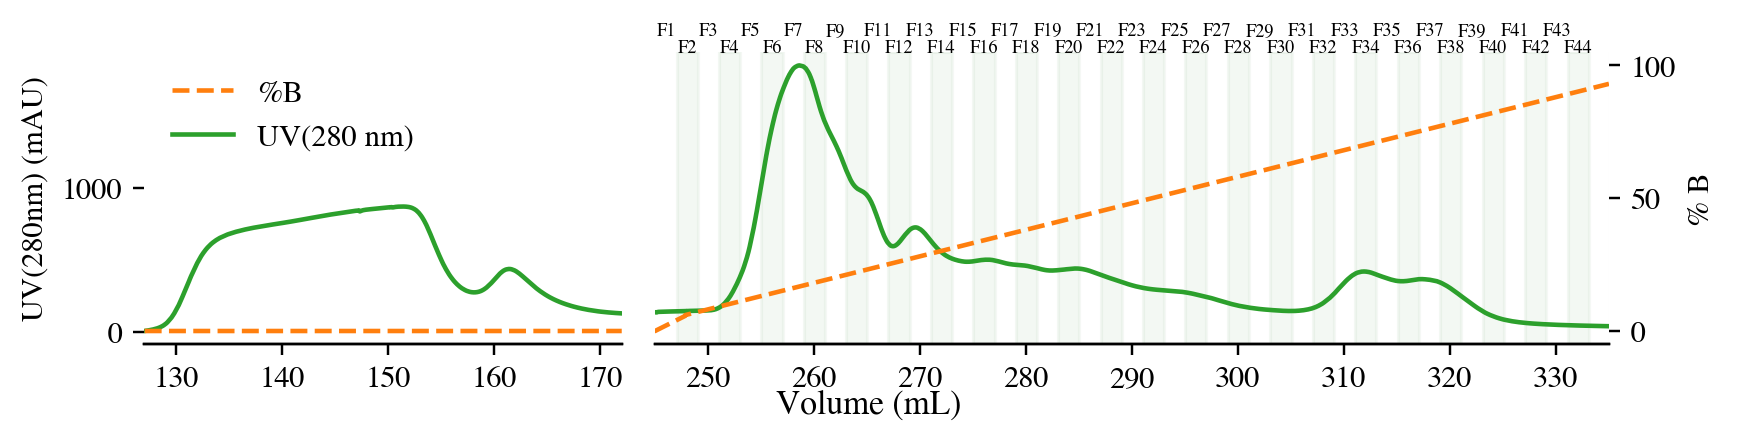

In [ ]:
band_colors = ['darkseagreen', (1,1,1)]
span = 80
x_min1 = 127
x_min2 = 245
x_max1 = x_min1 + 45
x_max2 = x_min2 + 90
fig, axs = plt.subplots(
    1, 2, sharey=True,
    figsize=(8,2), dpi=220,
    gridspec_kw={'width_ratios':[1,2]})

color_UV = sns.color_palette('tab10')[2]
color_B = sns.color_palette('tab10')[1]
# gs = gridspec.GridSpec(1, 3)

# ax0 = plt.subplot(gs[0,0])
# ax1 = plt.subplot(gs[0,1:3])
# axs = (ax0, ax1)
n = 0
for ax in axs:
    h, l = [], []
    
    # Plot fraction bands
    df_fracs_aec_7.apply(lambda x: ax.axvspan(x.start, x.end, color=band_colors[int(x.no%2)], alpha=0.1), axis=1)
    
    # Plot B
    v = '%B'
    x, y = [c for c in df_aec_7 if v in c]
    nax = sns.lineplot(x=df_aec_7.loc[df_aec_7[x]>x_min1, x], y=df_aec_7.loc[df_aec_7[x]>x_min1, y], label=v, color=color_B, ax=ax.twinx(), linestyle='--')
    hi, li = nax.get_legend_handles_labels()
    nax.legend().remove()
    h += hi
    l += li


    # Plot UV
    v = 'UV(280 nm)'
    x, y = [c for c in df_aec_7 if v in c]
    sns.lineplot(x=df_aec_7.loc[df_aec_7[x]>x_min1, x], y=df_aec_7.loc[df_aec_7[x]>x_min1, y], label=v, color=color_UV, ax=ax)
    hi, li = ax.get_legend_handles_labels()
    h += hi
    l += li
    ax.legend().remove()
    ax.set_xlabel('')

    
    sns.despine(left=True)
    if n == 0:
        ax.set_xlim(x_min1, x_max1)
        ax.set_ylabel('UV(280nm) (mAU)')
        nax.set_ylabel('')
        nax.set_yticks([])
    else:
        ax.set_xlim(x_min2, x_max2)
        ax.tick_params(axis='y', length=0)
        df_fracs_aec_7[(df_fracs_aec_7.end < x_max2) & (df_fracs_aec_7.start > x_min2)].apply(
            lambda x: nax.text(np.average((x.start, x.end)), 110,
                              'F{}'.format(int(x.no)), fontsize=6,
                              ha='center', va=['top','bottom'][int(x.no%2)]
                             ), axis=1)
        nax.set_ylabel('% B')
#         nax.set_ylim(-10,120)
#         ax.set_ylim(-1600,1900)
    n +=1

# ytx = ax.get_yticks()
# ax.set_yticklabels([])
# axs[0].set_yticks(ytx)

plt.tight_layout()  
axs[0].legend(h, l, frameon=False, loc='upper left')
fig.supxlabel('Volume (mL)', fontsize=11)

## SEC chromatogram

In [ ]:
df_sec_4 = pd.read_csv('../03-Lab_work/2206-Purification/Purification/220608_4C1_SEC.csv', skiprows=1)

In [ ]:
df_fracs_sec_4 = pd.read_csv(
    '../03-Lab_work/2206-Purification/Purification/fractions_4_SEC.txt',
    sep='\t', skiprows=2,
    names=['no', 'rackloc', 'tubeloc','start','end', 'vol'],
    usecols=['no', 'start', 'end']
)

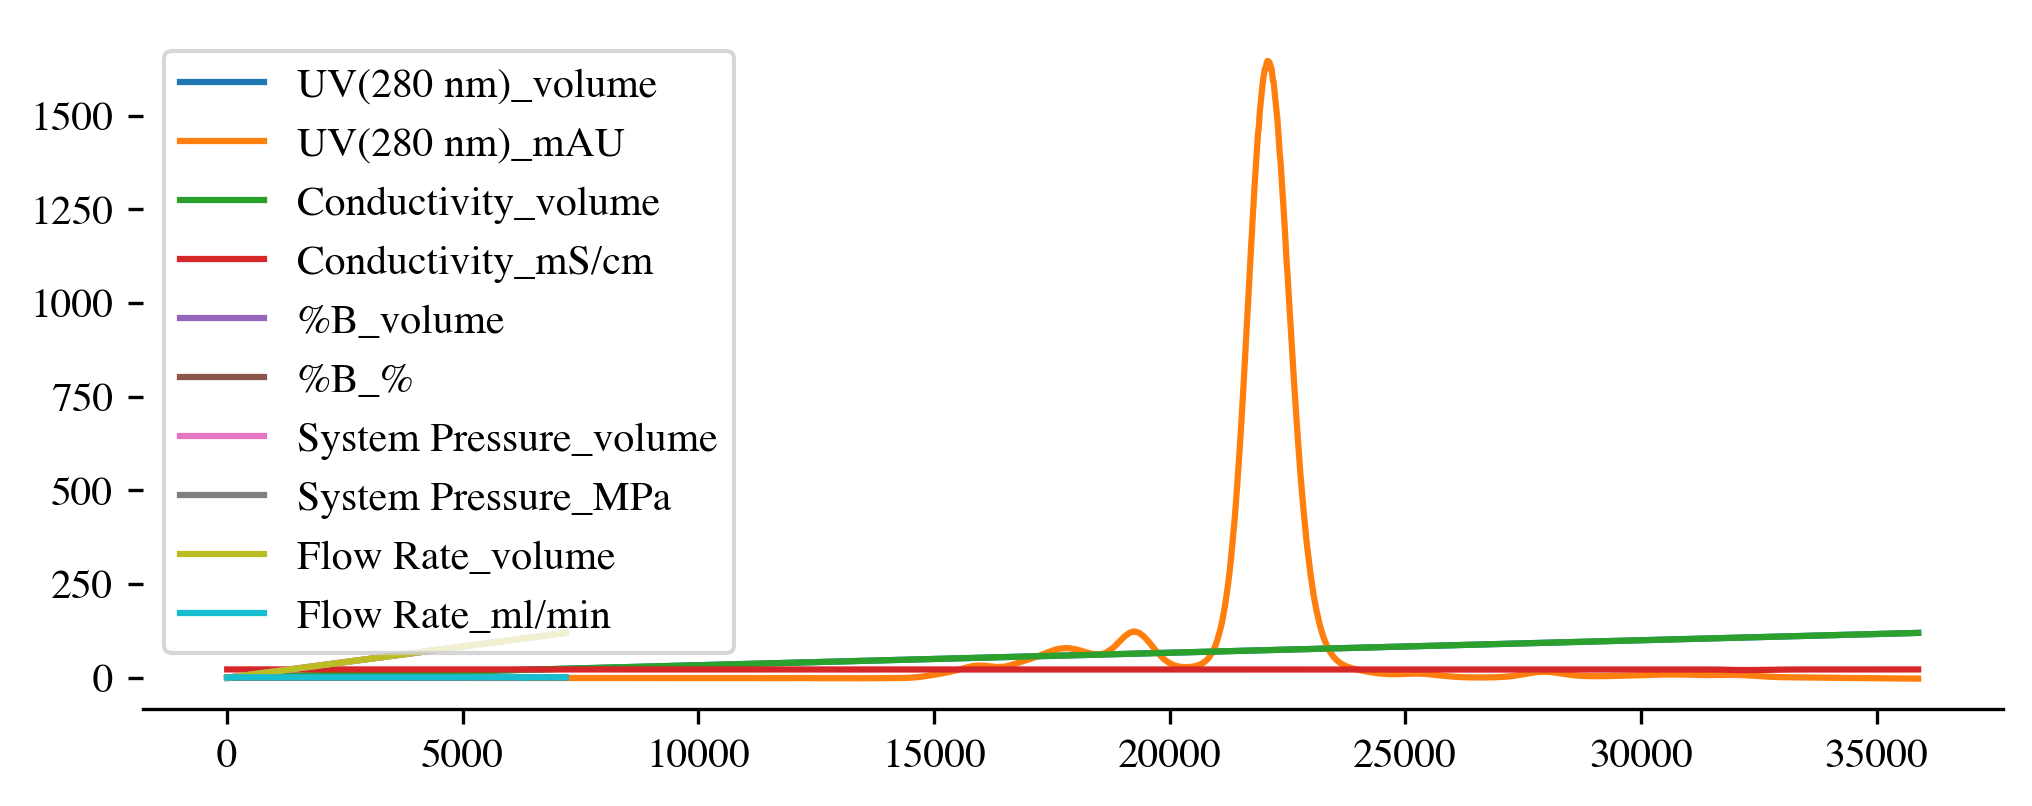

In [ ]:
# plt.figure(figsize=(10,2), dpi=300)
df_sec.plot(figsize=(8,3))
fig = plt.gcf()
fig.set_dpi(300)
sns.despine(left=True)

In [ ]:
list(set([c.split('_')[0] for c in df_sec]))

['%B', 'UV(280 nm)', 'Flow Rate', 'System Pressure', 'Conductivity']

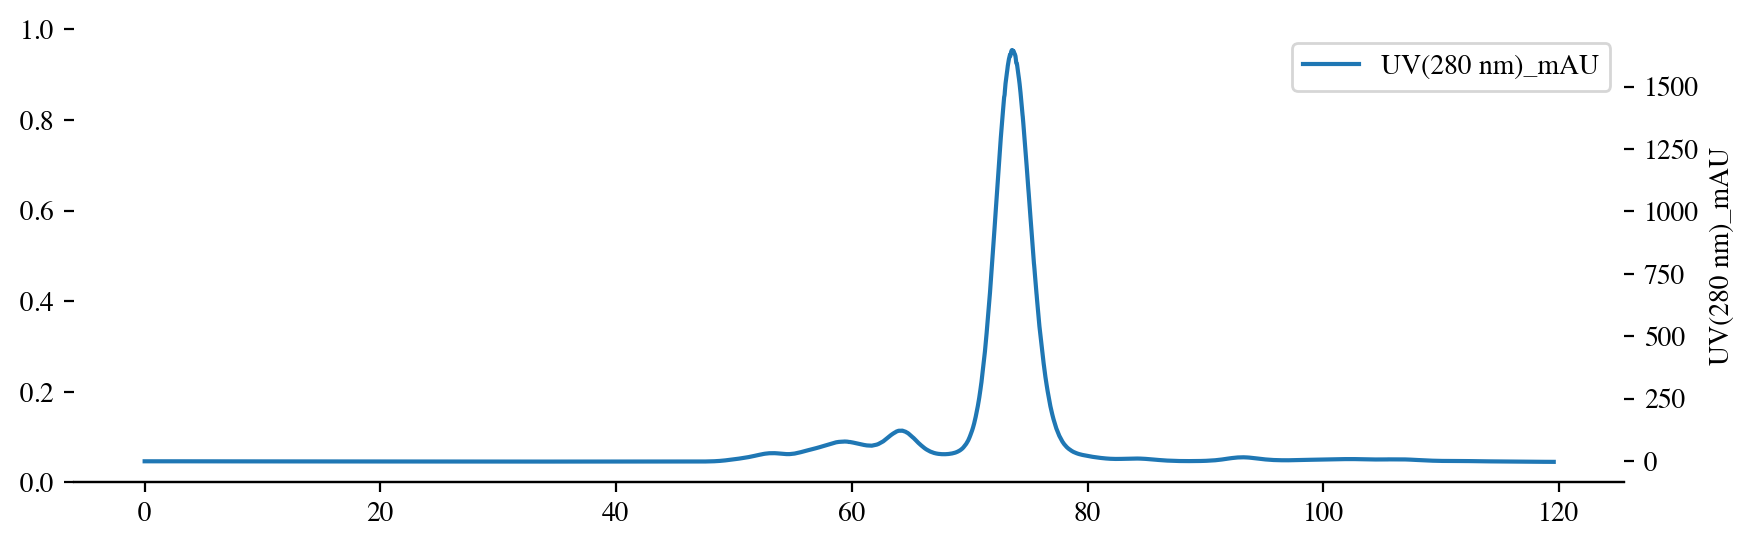

In [ ]:
vrs = [
#    '%B',
    'UV(280 nm)',
#    'Flow Rate',
#    'System Pressure',
#    'Conductivity'
]
plt.figure(figsize=(10,3), dpi=200)
ax = plt.axes()
for v in vrs:
    nax = ax.twinx()
    x, y = [c for c in df_sec_4 if v in c]
    sns.lineplot(x=df_sec_4[x], y=df_sec_4[y], label=y, ax=nax)
sns.despine(left=True)

In [ ]:
df_sec_4

,UV(280 nm)_volume,UV(280 nm)_mAU,Conductivity_volume,Conductivity_mS/cm,%B_volume,%B_%,System Pressure_volume,System Pressure_MPa,Flow Rate_volume,Flow Rate_ml/min
0,0.000250,-0.167650,0.000250,22.066490,0.000000,0.0,0.005917,-0.034474,0.000000,0.0
1,0.001833,-0.167450,0.001833,22.066490,0.003250,0.0,0.020833,-0.034474,0.000000,1.0
2,0.004250,-0.167249,0.004250,22.066490,0.015833,0.0,0.037500,-0.020684,0.003250,1.0
3,0.005917,-0.167048,0.005917,22.065371,0.032500,0.0,0.054167,0.020684,0.015833,1.0
4,0.007500,-0.166746,0.007500,22.101574,0.049167,0.0,0.070833,0.068948,0.032500,1.0
...,...,...,...,...,...,...,...,...,...,...
35877,119.543236,-2.429941,119.543236,22.072159,NaN,NaN,NaN,NaN,NaN,NaN
35878,119.546570,-2.430732,119.546570,22.072159,NaN,NaN,NaN,NaN,NaN,NaN
35879,119.549904,-2.431741,119.549904,22.036562,NaN,NaN,NaN,NaN,NaN,NaN
35880,119.549904,-2.432749,119.549904,22.036562,NaN,NaN,NaN,NaN,NaN,NaN


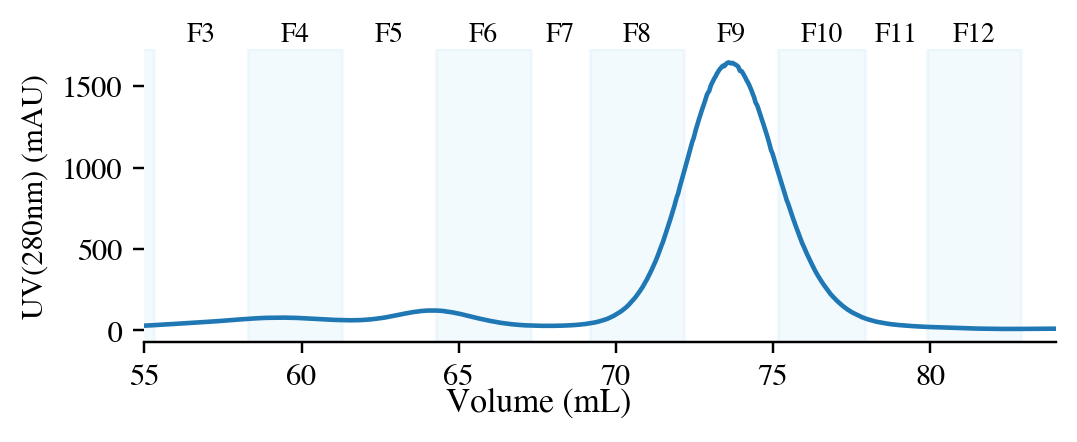

In [ ]:
band_colors = ['lightskyblue', (1,1,1)]
x_min, x_max = (55, 84)
fig, ax = plt.subplots(1, 1, figsize=(5,2), dpi=220)

## Plot fraction bands
df_fracs_sec_4.apply(lambda x: ax.axvspan(x.start, x.end, color=band_colors[int(x.no%2)], alpha=0.1), axis=1)

# # Plot flow
# v = '%B'
# x, y = [c for c in df_sec_4 if v in c]
# color = sns.color_palette('tab10')[1]
# nax = sns.lineplot(x=df_sec_4.loc[df_sec_4[x]>90, x], y=df_sec_4.loc[df_sec_4[x]>90, y], label=v, color=color, ax=ax.twinx(), linestyle='--')
# hi, li = nax.get_legend_handles_labels()
# nax.legend().remove()
# h += hi
# l += li


# Plot UV
v = 'UV(280 nm)'
x, y = [c for c in df_sec_4 if v in c]
sub_df = df_sec_4[df_sec_4[x].between(x_min, x_max)]
color = sns.color_palette('tab10')[0]
sns.lineplot(x=sub_df[x], y=sub_df[y], label=v, color=color, ax=ax)
hi, li = ax.get_legend_handles_labels()
h += hi
l += li
ax.legend().remove()
ax.set_xlabel('')


# sns.despine(left=True)
# if n == 0:
#     ax.set_xlim(100, 180)
ax.set_ylabel('UV(280nm) (mAU)')
#     nax.set_ylabel('')
#     nax.set_yticks([])
# else:
ax.set_xlim(x_min, x_max)
#     ax.tick_params(axis='y', length=0)
df_fracs_sec_4[(df_fracs_sec_4.start>x_min) & (df_fracs_sec_4.end<x_max)].apply(
    lambda x: ax.text(np.average((x.start, x.end)), 1900,
                      'F{}'.format(int(x.no)), fontsize=9,
                      ha='center', va='top'
                     ), axis=1)

# ytx = ax.get_yticks()
# ax.set_yticklabels([])
# axs[0].set_yticks(ytx)

plt.tight_layout()  
axs[0].legend(h, l, frameon=False, loc='upper left')
fig.supxlabel('Volume (mL)', fontsize=11)
sns.despine(left=True)